<a href="https://colab.research.google.com/github/DrLux/MountainCar-v0/blob/master/MountainCar-v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descrizione di MountainCar sulla pagina di OpenAi Gym:  [link github](https://github.com/openai/gym/wiki/MountainCar-v0)

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
from pyvirtualdisplay import Display
import gym
import numpy as np
import math
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

from gym import logger as gymlogger
SARSA = 1
EXPECTED_SARSA = 2
QLEARNING = 3

In [0]:
#Stampa a schermo il video 
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = max(mp4list) #prendo l' ultimo video
    print(mp4list)
    print(mp4)
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

#Crea un dump video dell' episodio 
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
class Agent:
  env = None
  Q_table = None
  position_bins = None
  velocity_bins = None
  alpha = 0
  gamma = 0
  epsilon = 0
  list_episodes = None 
  list_cum_rewards = None
  algo = 0
  
  def __init__(self, env):
    self.list_episodes = list()
    self.list_cum_rewards = list()
    self.env = env
          
  def sarsa_update(self,observation, action, reward, new_obs, new_action):
    q = self.Q_table[observation][action]
    q_next = self.Q_table[new_obs][new_action] #l'new_action è stata estratta seguendo la policy
    self.Q_table[observation][action] += self.alpha * (reward + self.gamma*q_next - q)
    
  def exp_sarsa_update(self,observation, action, reward, new_obs):
    q = self.Q_table[observation][action]
    V = np.dot(self.epsilon_greedy_policy(new_obs), self.Q_table[new_obs][:])#dot product tra le azioni e le loro probabilità secondo la policy    
    self.Q_table[observation][action] += self.alpha * (reward + self.gamma*V - q)
    
  def qlearning_update(self,observation, action, reward, new_obs):
    q = self.Q_table[observation][action]
    best_action = np.argmax(np.array(self.Q_table[new_obs])) #prendo l' azione migliore 
    V = self.Q_table[new_obs][best_action]
    self.Q_table[observation][action] += self.alpha * (reward + self.gamma*V - q)
    
  def epsilon_greedy_policy(self, observation):
    total_actions = self.env.action_space.n
    best_action = np.argmax(np.array(self.Q_table[observation]))
    greedy_prob = 1 - self.epsilon
    non_greedy_prob = self.epsilon / (total_actions-1) #le altre azioni si dividono le epsilon_prob restanti
    distr_prob = np.full(total_actions, non_greedy_prob) #inizializzo tutte le azioni con le epsilon_prob
    distr_prob[best_action] = greedy_prob #aggiorno le prob dell' azione migliore
    return distr_prob
    
  def get_action(self, observation):
    prob_actions = self.epsilon_greedy_policy(observation)
    action = int(np.random.choice(self.env.action_space.n, 1, p=prob_actions)) #pesco l' azione secondo la distrib. di prob generata dalla policy
    return action 

  def statistics(self):
    if self.algo == 1:
      algorithm = "SARSA"
    elif self.algo == 2:
      algorithm = "EXPECTED_SARSA"
    elif self.algo == 3:
      algorithm = "Q_LEARNING"
    else: 
      algorithm = "unknown"
          
    title = "Algo: "+ algorithm + " | alpha: "+str(self.alpha)+"| gamma: "+str(self.gamma)+" | epsilon: "+str(self.epsilon )+" | pos: "+str(len(self.position_bins))+" | vel: "+str(len(self.velocity_bins))
    plt.title(title)
    plt.plot(self.list_episodes, self.list_cum_rewards)  
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.show()
      
  def training(self, max_episodes, bin_1, bin_2, alpha, gamma, epsilon, update_algo, max_steps = 200, debug = False):
    self.list_episodes.clear()
    self.list_cum_rewards.clear()
    self.position_bins = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], num = bin_1, endpoint=True)
    self.velocity_bins = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], num = bin_2, endpoint=True)
    self.Q_table = np.zeros((bin_1, bin_2, self.env.action_space.n)) 
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.algo = update_algo
    start_epsilon_value = epsilon
    cum_reward = 0
    steps = 0
    
    alphas = np.linspace(1.0, 0.02, max_episodes)

    
    for episode in range(max_episodes):
      self.alpha = alphas[episode]
      done = False
      steps = 0
      cum_reward = 0
      self.epsilon = start_epsilon_value * np.power(0.9, (episode/100))#decremento l' esplorazione ogni 100 steps

      
      observation = self.env.reset() 
      observation =  ( int(np.digitize(observation[0], self.position_bins,  right=True).astype(int)), 
                      int(np.digitize(observation[1], self.velocity_bins, right=True).astype(int)) )
      
      while (not done and steps < max_steps):
        #env.render()
        
        action = self.get_action(observation) 
        new_obs, reward, done, info = self.env.step(action)
        new_obs = (int(np.digitize(new_obs[0], self.position_bins,  right=True).astype(int)), 
                   int(np.digitize(new_obs[1], self.velocity_bins, right=True).astype(int)))
        if update_algo == SARSA:  
          new_action = self.get_action(new_obs) 
          self.sarsa_update(observation, action, reward, new_obs, new_action)
          action = new_action
        elif update_algo == EXPECTED_SARSA:
            self.exp_sarsa_update(observation, action, reward, new_obs)
        else:
          self.qlearning_update(observation, action, reward, new_obs)
        observation = new_obs
        cum_reward += reward
        steps += 1

      self.list_cum_rewards.append(cum_reward)
      self.list_episodes.append(episode)
      
      if debug:
        if(episode % 100 == 0):
          print("\n#################\n")
          print("Episode: ", episode)
          print("Reward: ", cum_reward)
          print("Total Rewards: ", sum(self.list_cum_rewards))
          print("Epsilon: ", self.epsilon)


In [0]:
def dump_plot(x_label, xaxis_values, sarsa_rewards_high, exp_sarsa_rewards_high, ql_rewards_high, sarsa_rewards_low, exp_sarsa_rewards_low, ql_rewards_low):
  plt.plot(xaxis_values, sarsa_rewards_high, "r-")
  plt.plot(xaxis_values, exp_sarsa_rewards_high, "bs-")
  plt.plot(xaxis_values, ql_rewards_high, "g^-")

  plt.plot(xaxis_values, sarsa_rewards_low, 'r--')
  plt.plot(xaxis_values, exp_sarsa_rewards_low, 'bs--')
  plt.plot(xaxis_values, ql_rewards_low, 'g^--')

  plt.xlabel(x_label)
  plt.ylabel('Cumulative Rewards')
  plt.legend(['n=6000 Sarsa ', 'n=6000 Expected Sarsa', 'n=6000 Q-learning', 'n=1000 Sarsa ', 'n=1000 Expected Sarsa', 'n=1000 Q-learning'], loc='best')
  plt.show()

In [0]:
def benchmark(dim, agent, position_bins, velocity_bins, report_rewards, algo, alpha, epsilon):
  agent.training(dim, position_bins, velocity_bins, alpha, 0.999, epsilon, algo)
  report_rewards.append(sum(a.list_cum_rewards)/a.list_episodes[-1])
  agent.statistics()


# Raccolgo statistiche sulle prestazioni al variare delle** dimensioni del' environment**.
(non ho potuto impostare un ciclo in quanto i valori dei bins non inseriti manualmente)

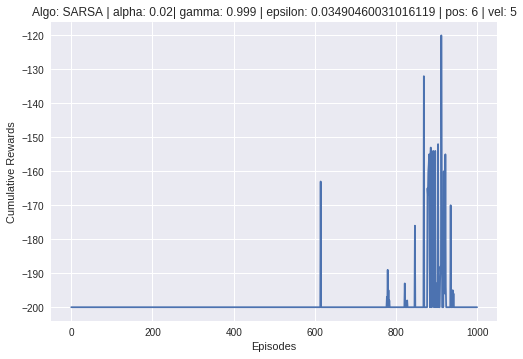

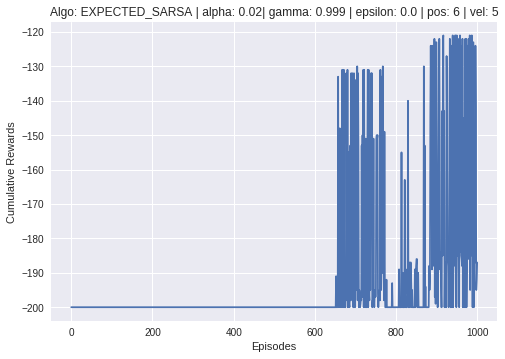

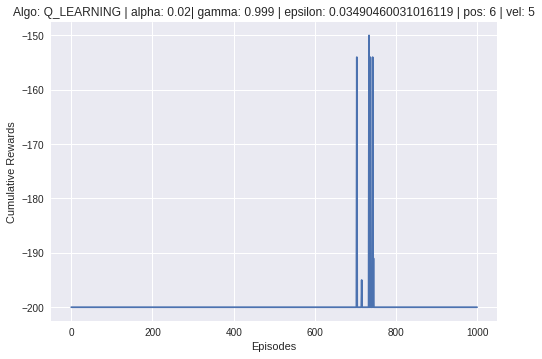

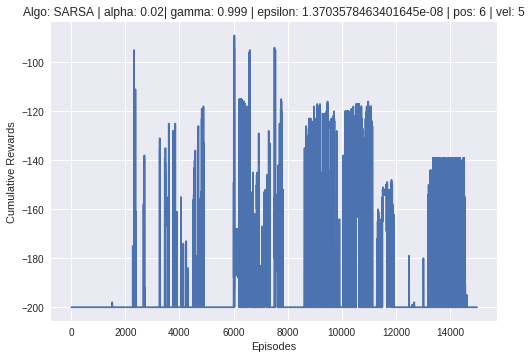

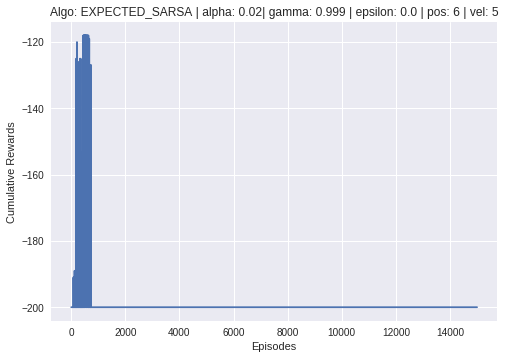

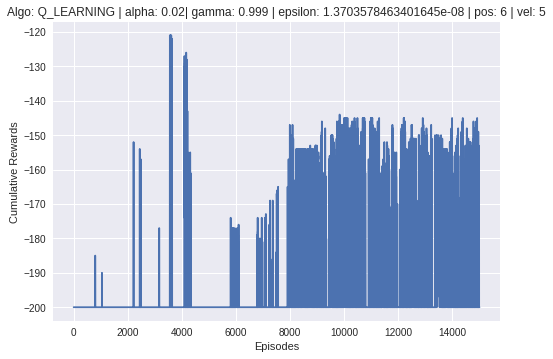

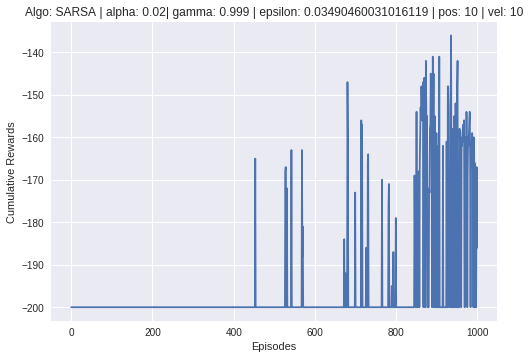

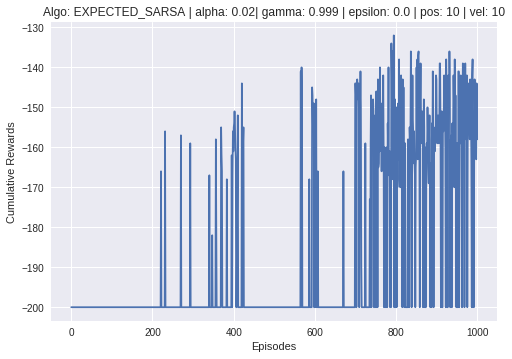

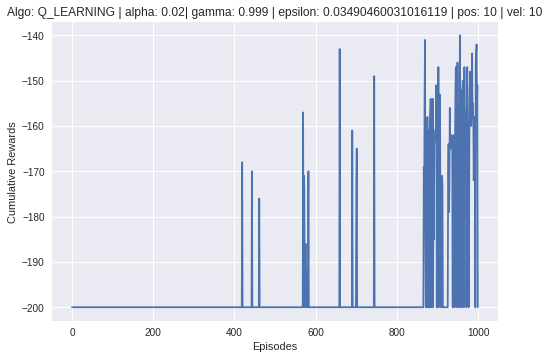

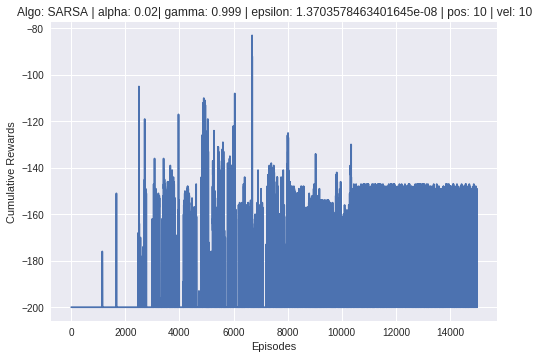

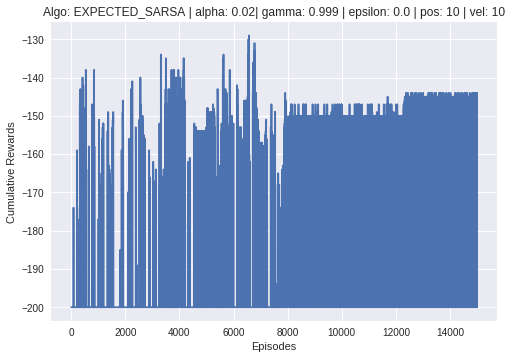

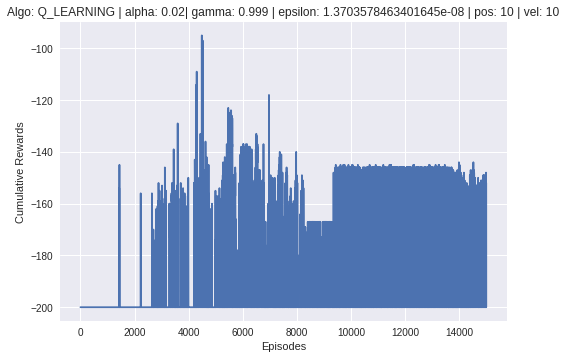

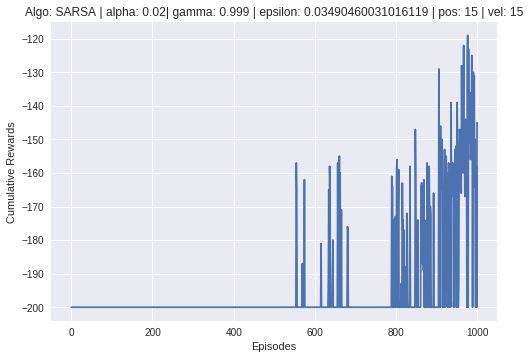

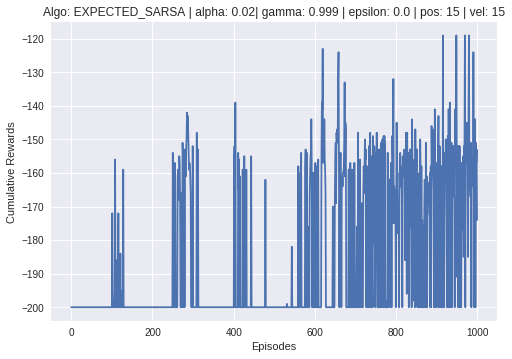

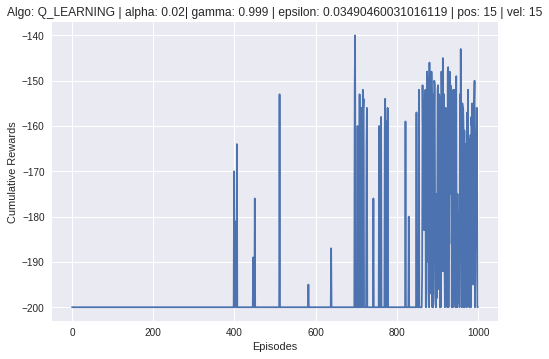

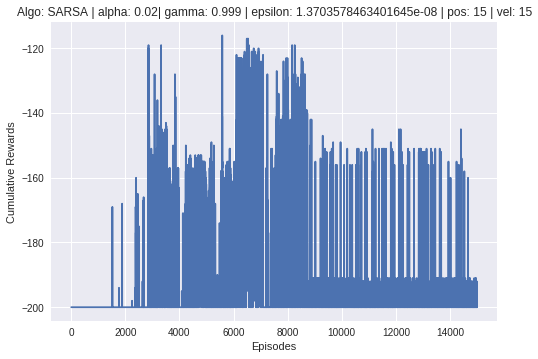

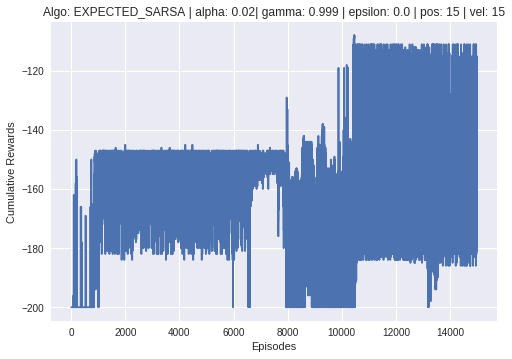

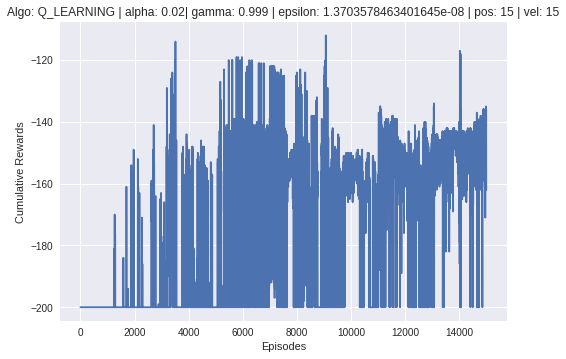

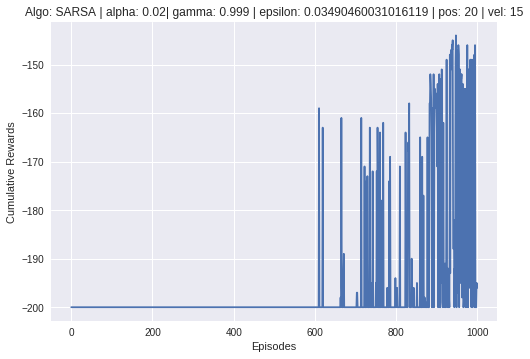

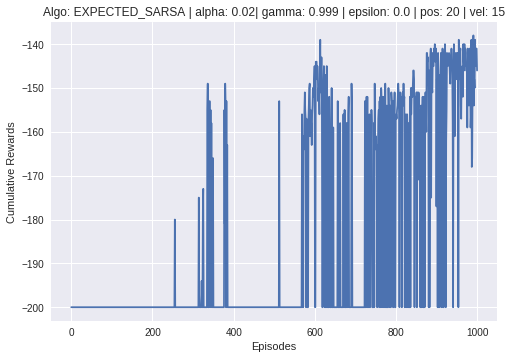

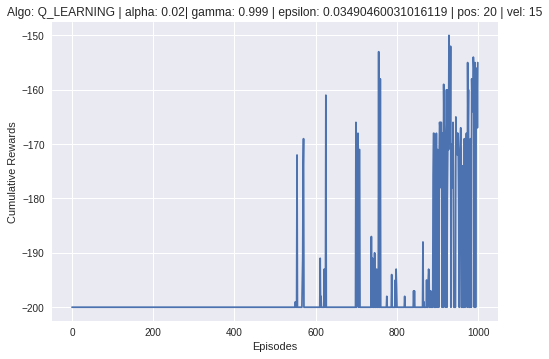

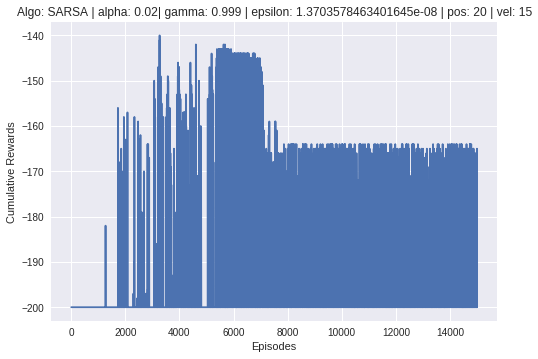

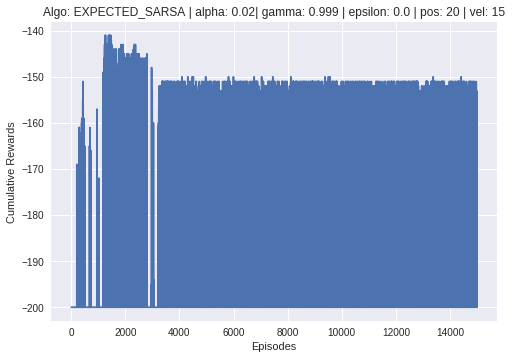

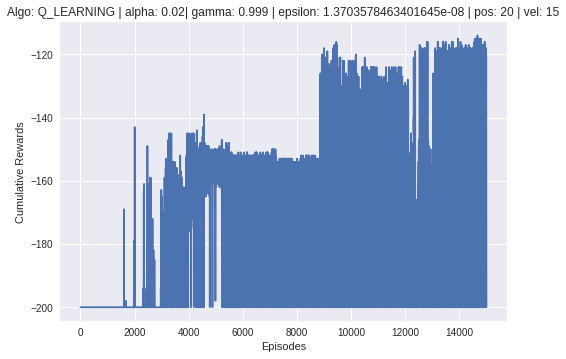

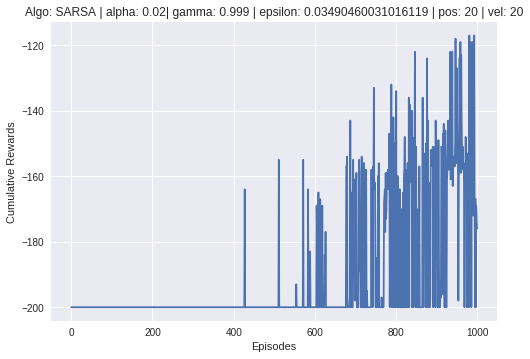

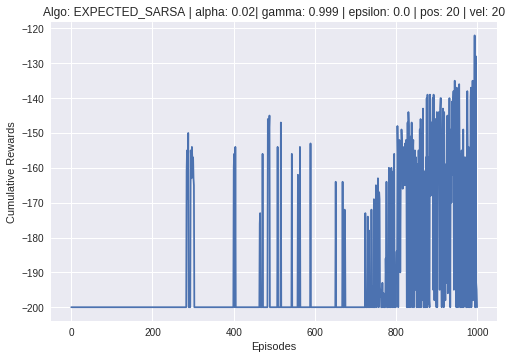

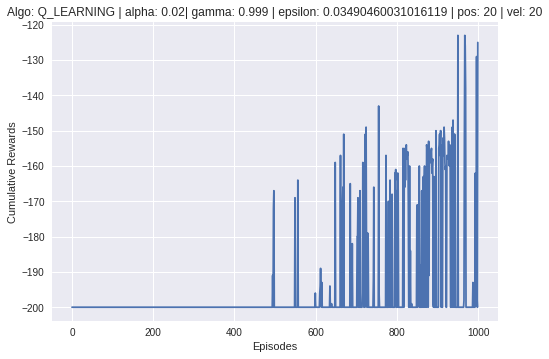

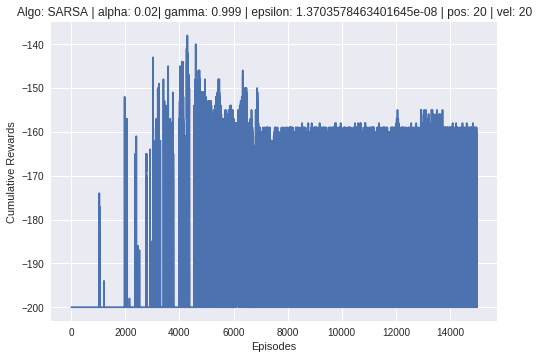

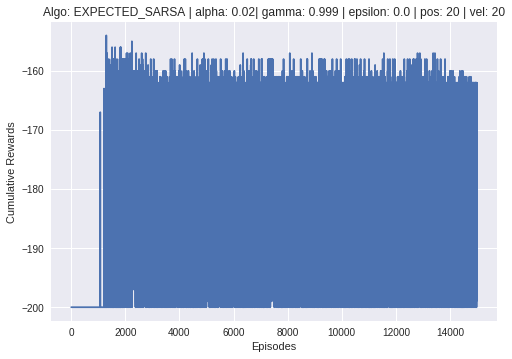

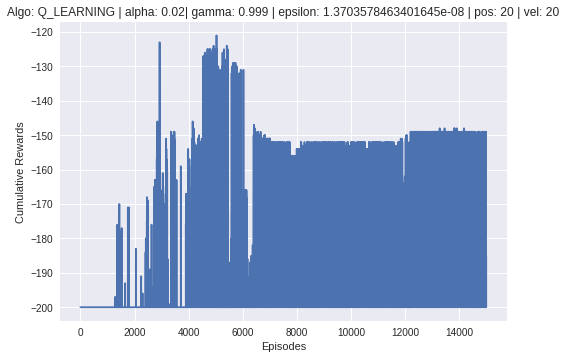

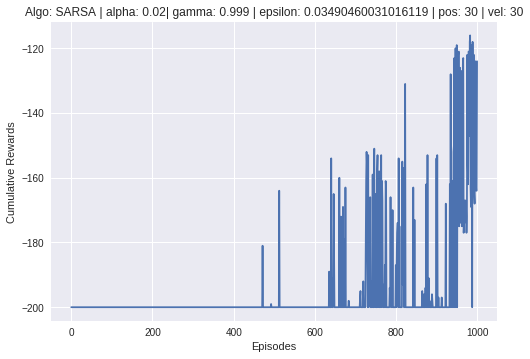

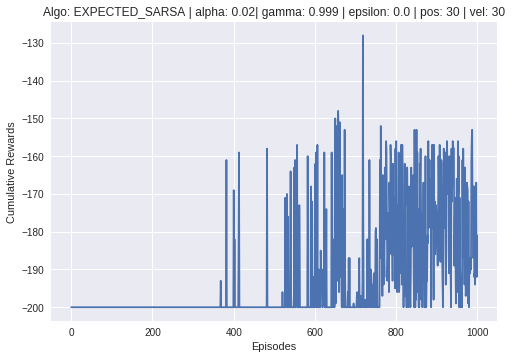

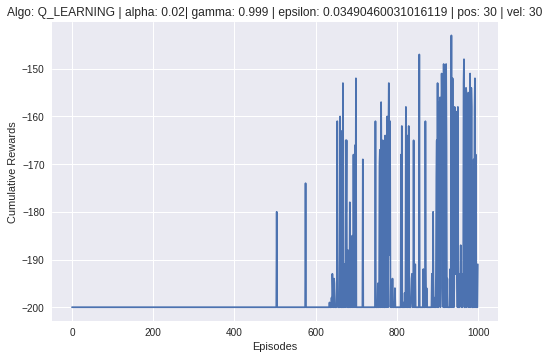

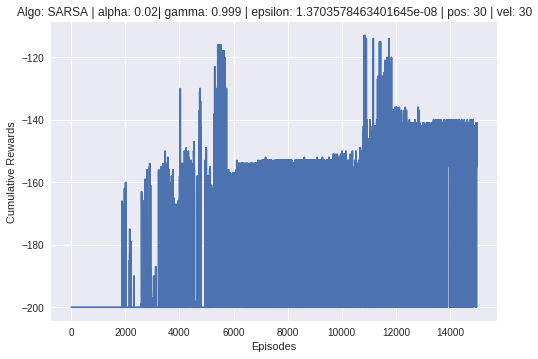

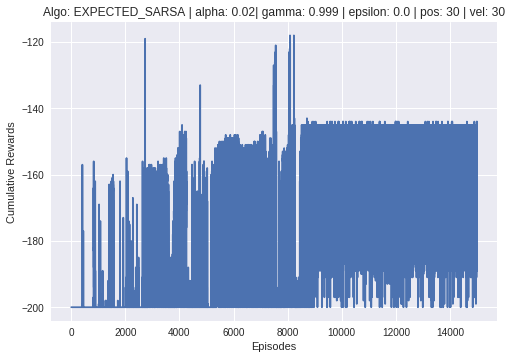

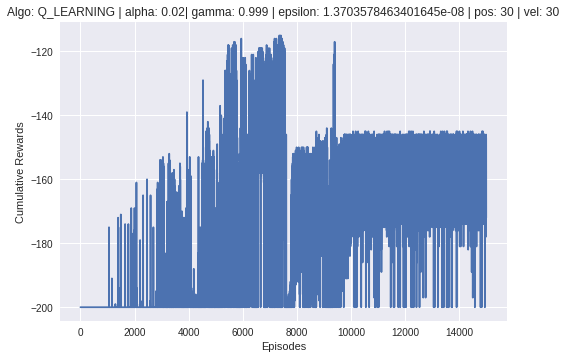

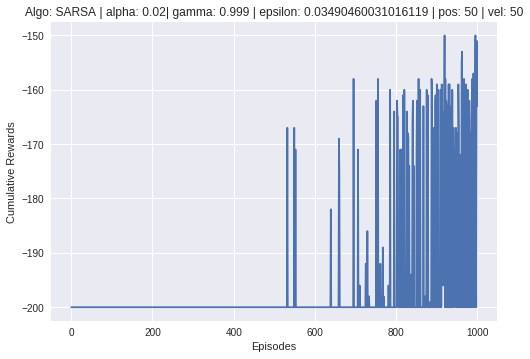

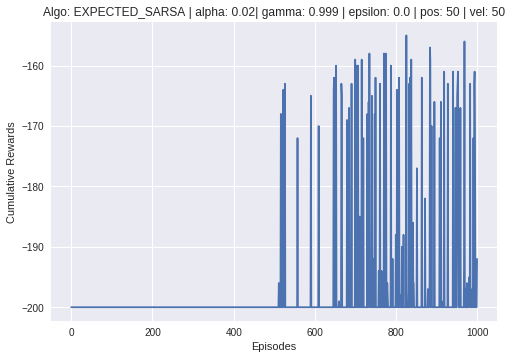

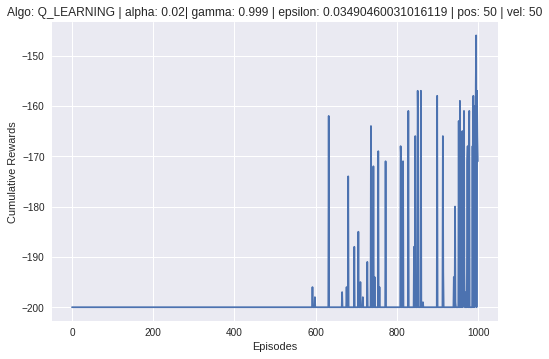

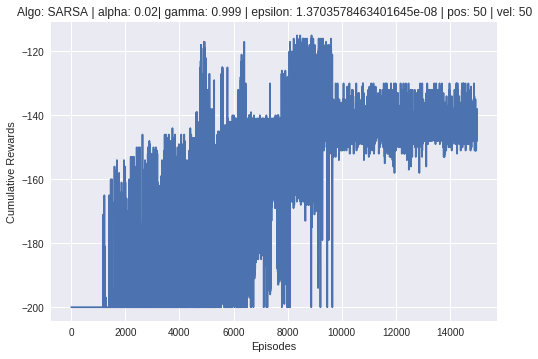

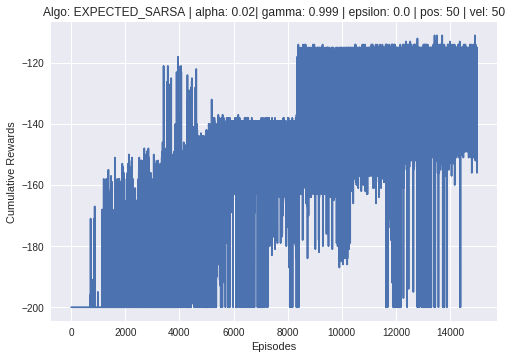

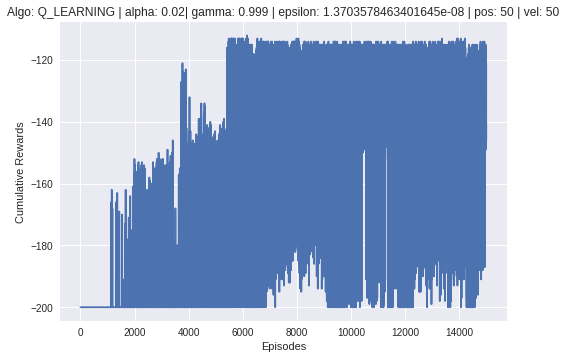

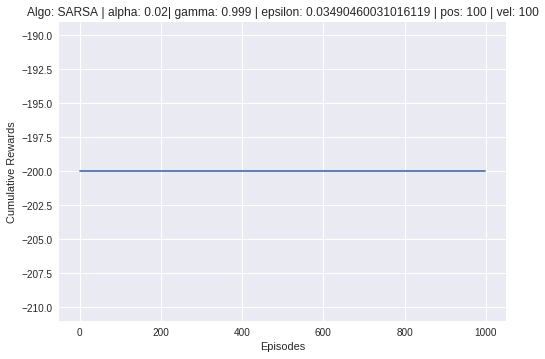

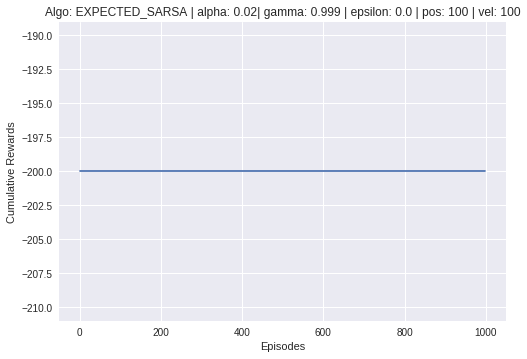

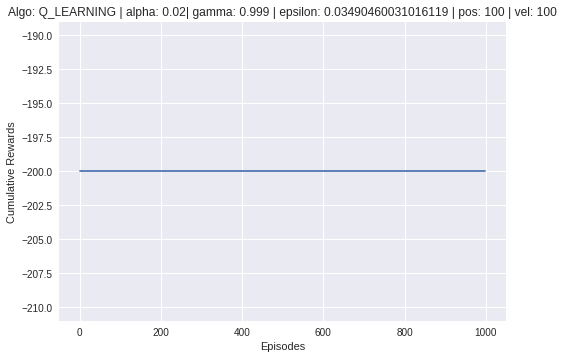

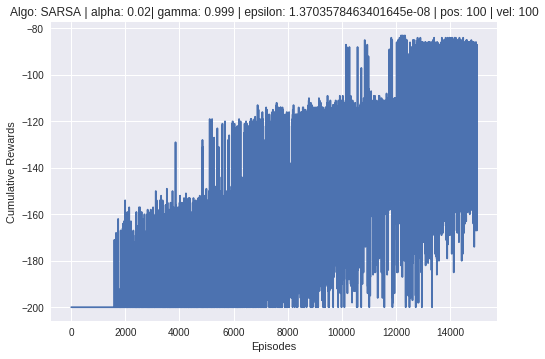

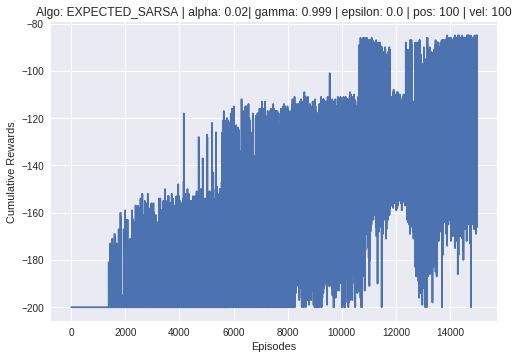

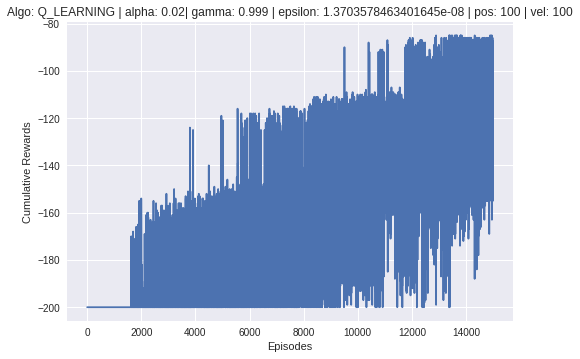

In [0]:
env = gym.make("MountainCar-v0")
a = Agent(env)

dimensions = list()

sarsa_report_rewards_low = list()
exp_sarsa_report_rewards_low = list()
ql_report_rewards_low = list()

sarsa_report_rewards_high = list()
exp_sarsa_report_rewards_high = list()
ql_report_rewards_high = list()

sarsa_alpha = 0.1
exp_sarsa_alpha = 0.2
ql_alpha = 0.3

sarsa_epsilon = 0.1
exp_sarsa_epsilon = 0
ql_epsilon = 0.1

dim1 = 1000
dim2 = 15000

# 6x5
position_bins = 6 
velocity_bins = 5
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)

# 10 x 10
position_bins = 10 
velocity_bins = 10
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)

# 15 x 15
position_bins = 15 
velocity_bins = 15
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)

# 20 x 15
position_bins = 20 
velocity_bins = 15
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)


# 20 x 20
position_bins = 20 
velocity_bins = 20
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)


# 30 x 30
position_bins = 30 
velocity_bins = 30
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)


# 50 x 50
position_bins = 50
velocity_bins = 50
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)


# 100 x 100
position_bins = 100 
velocity_bins = 100
dimensions.append(position_bins + velocity_bins )

benchmark(dim1, a, position_bins, velocity_bins, sarsa_report_rewards_low, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, exp_sarsa_report_rewards_low, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim1, a, position_bins, velocity_bins, ql_report_rewards_low, QLEARNING, ql_alpha, ql_epsilon)

benchmark(dim2, a, position_bins, velocity_bins, sarsa_report_rewards_high, SARSA, sarsa_alpha, sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, exp_sarsa_report_rewards_high, EXPECTED_SARSA, exp_sarsa_alpha, exp_sarsa_epsilon)
benchmark(dim2, a, position_bins, velocity_bins, ql_report_rewards_high, QLEARNING, ql_alpha, ql_epsilon)

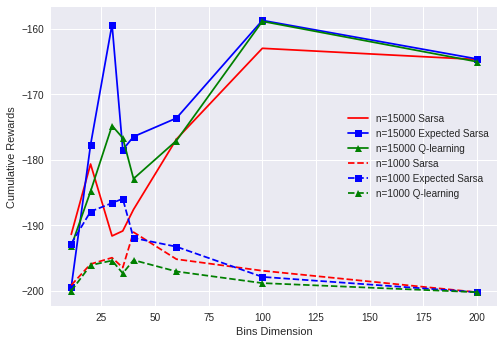

In [0]:
dump_plot('Bins Dimension', dimensions, sarsa_report_rewards_high, exp_sarsa_report_rewards_high, ql_report_rewards_high, sarsa_report_rewards_low, exp_sarsa_report_rewards_low, ql_report_rewards_low)

# Raccolgo statistiche sulle prestazioni al variare del **learning rate**
---



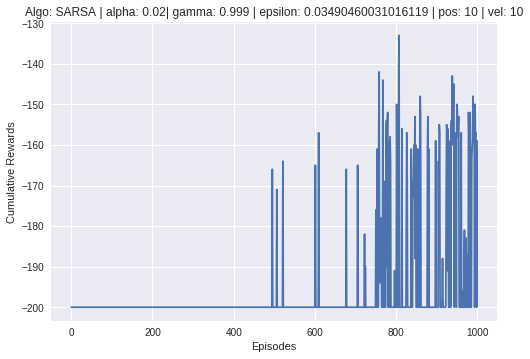

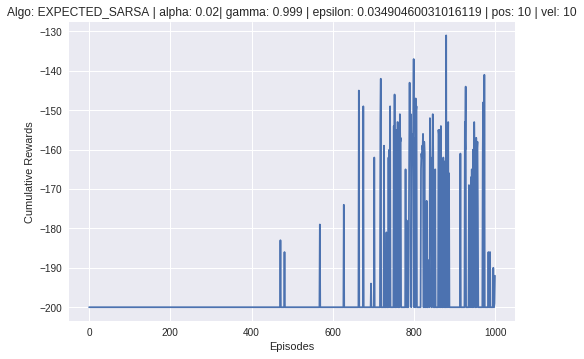

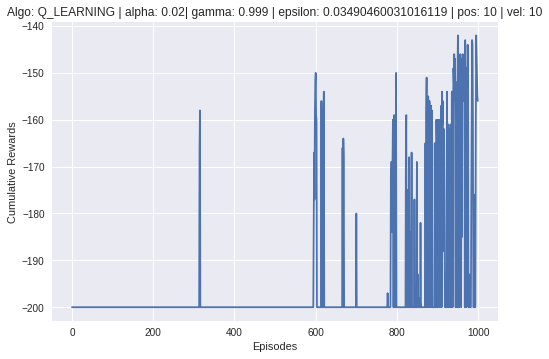

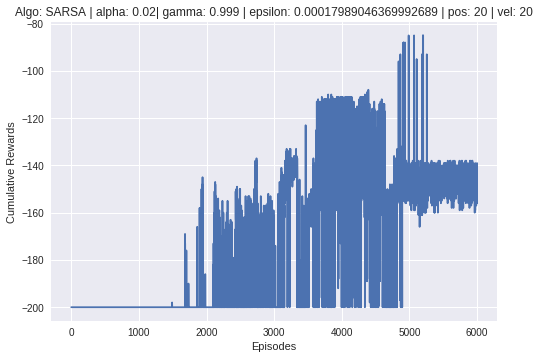

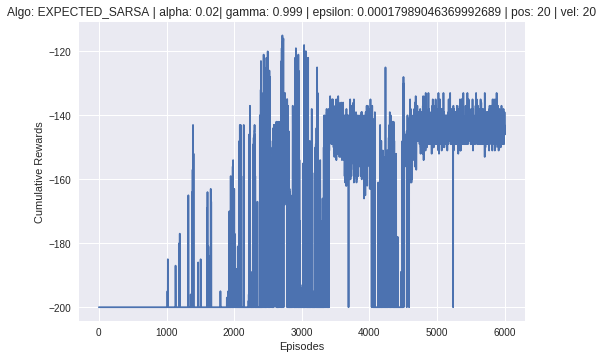

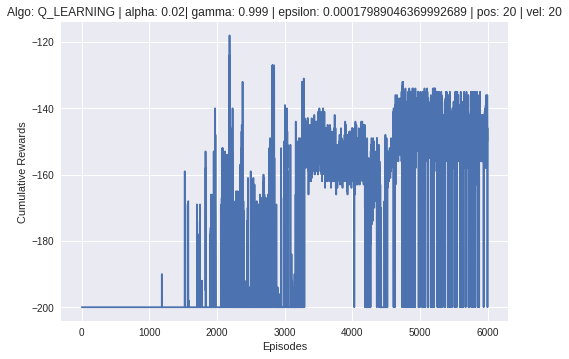

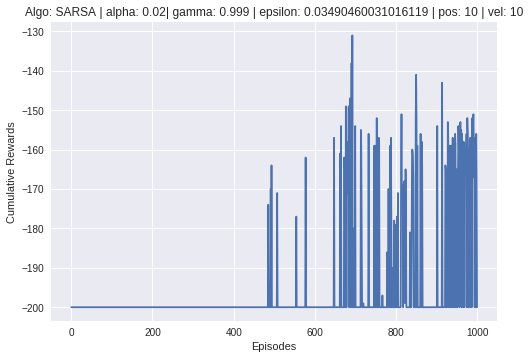

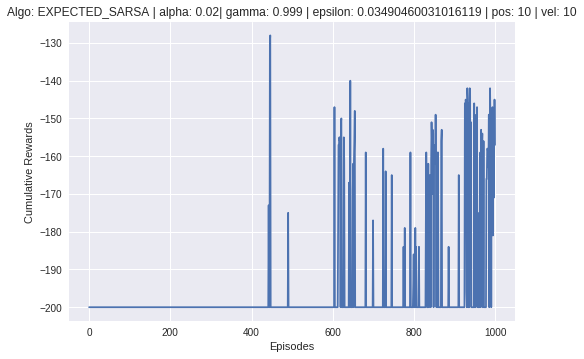

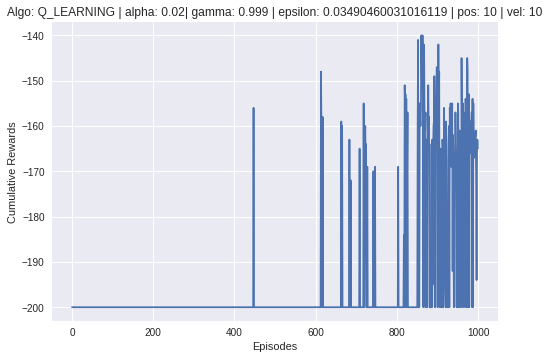

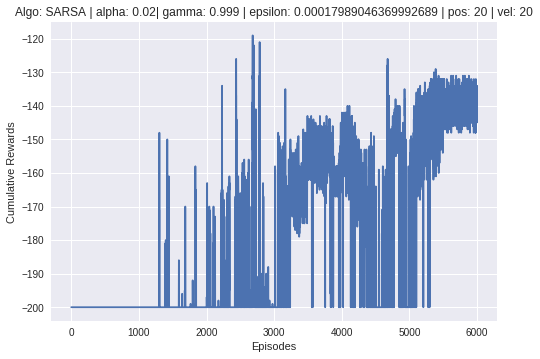

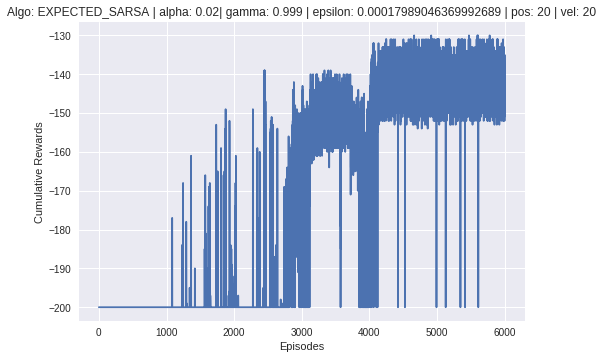

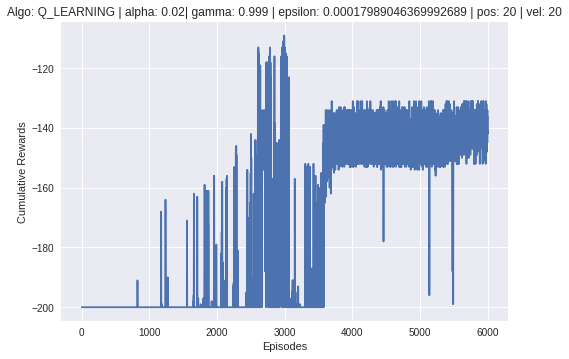

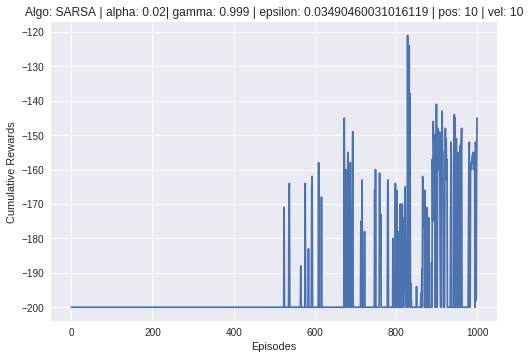

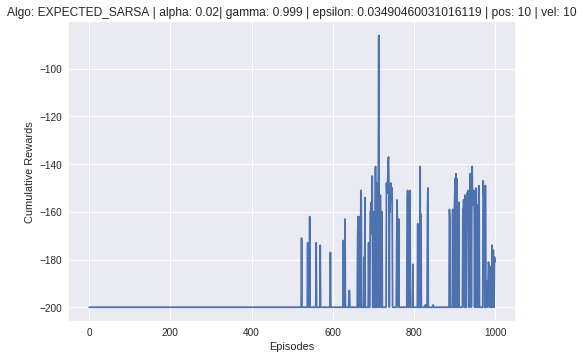

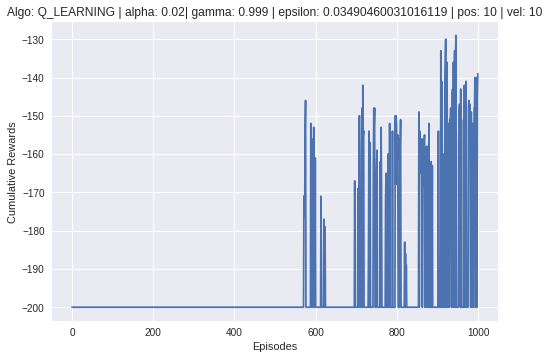

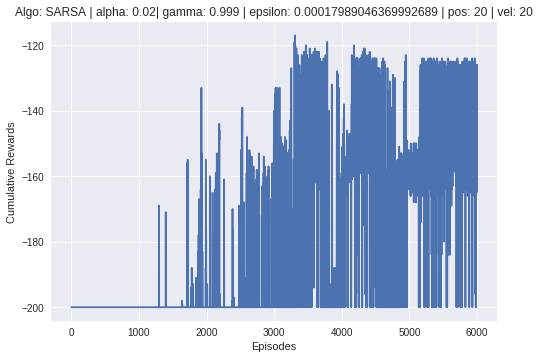

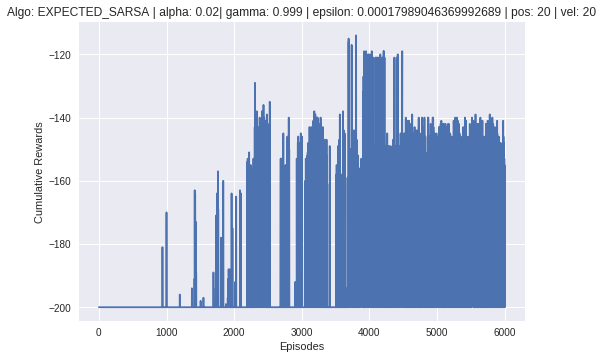

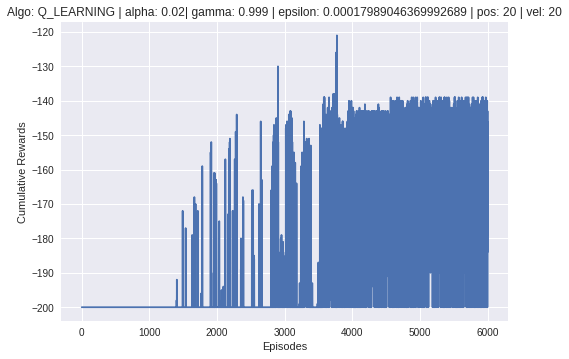

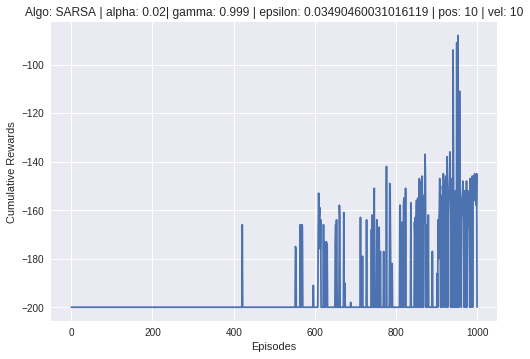

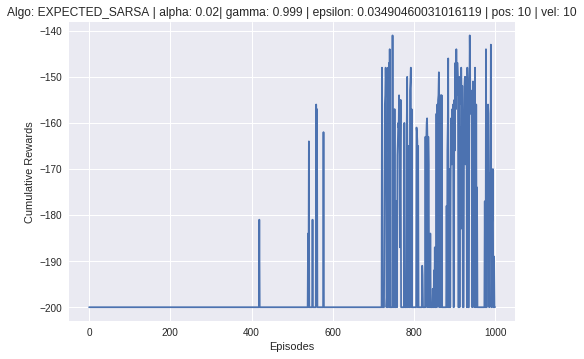

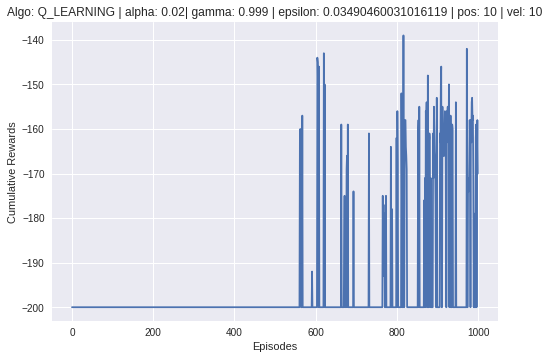

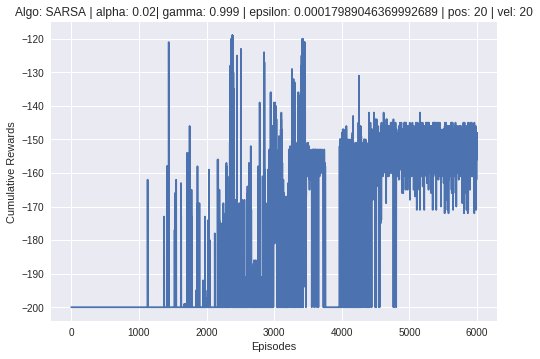

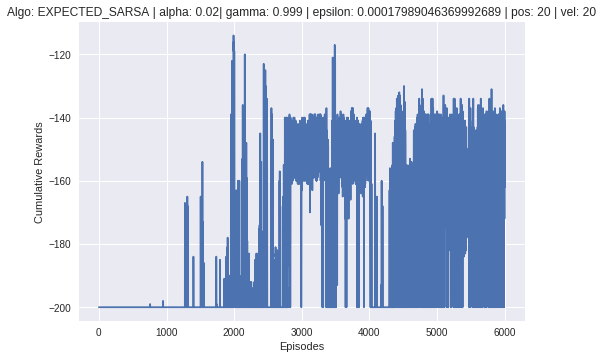

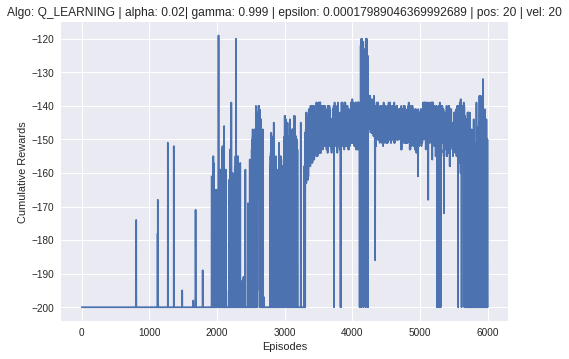

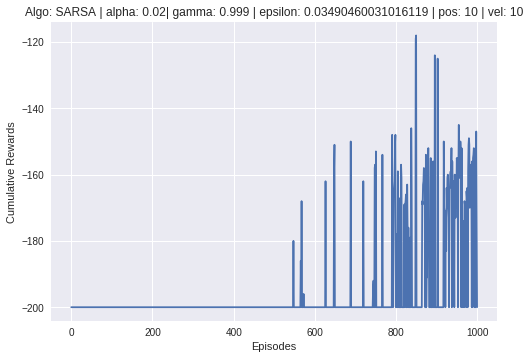

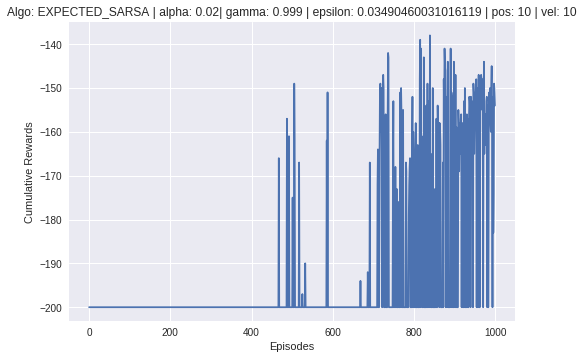

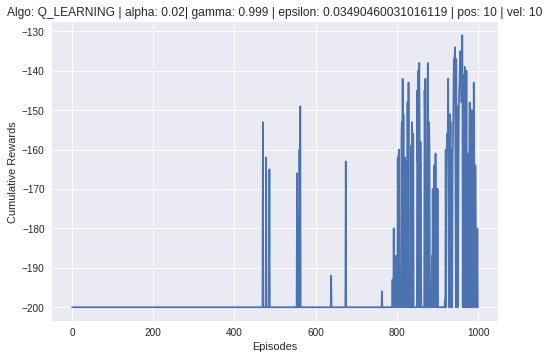

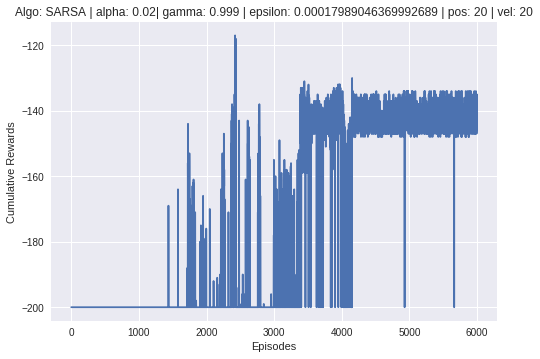

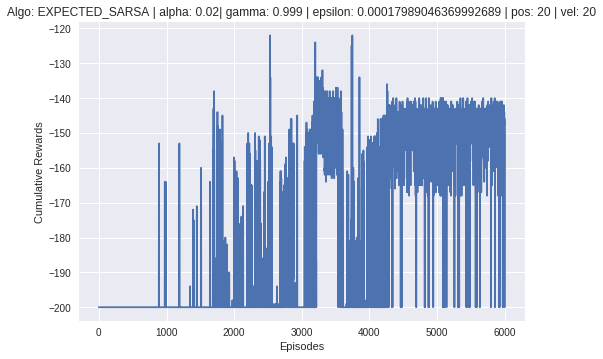

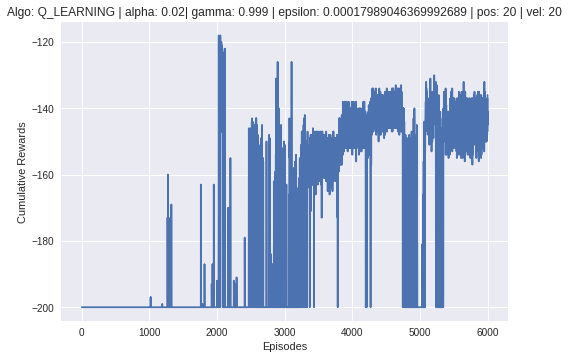

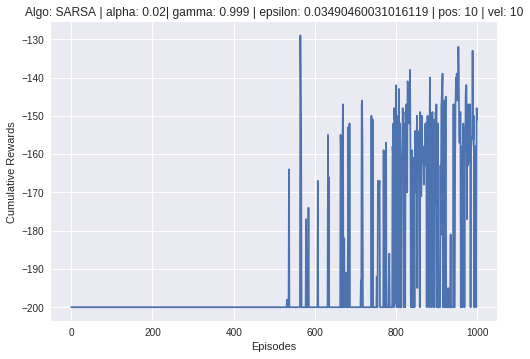

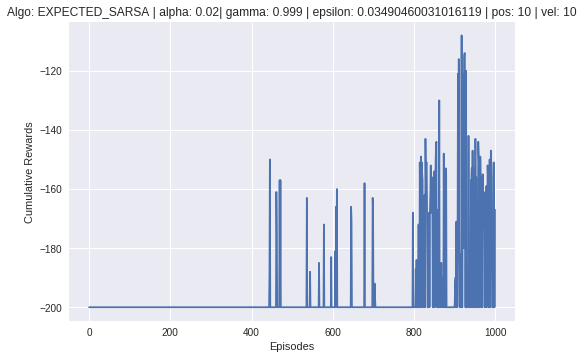

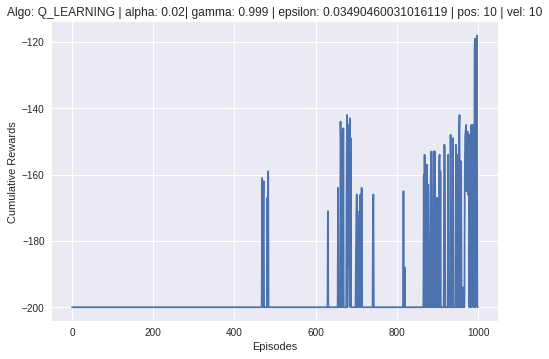

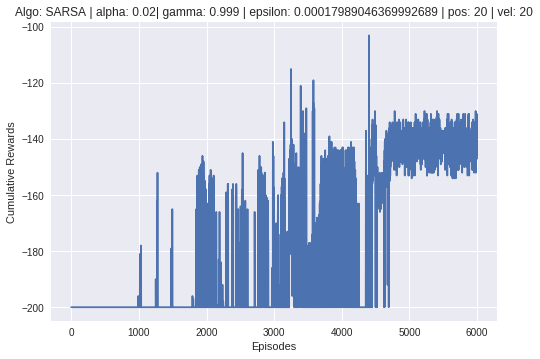

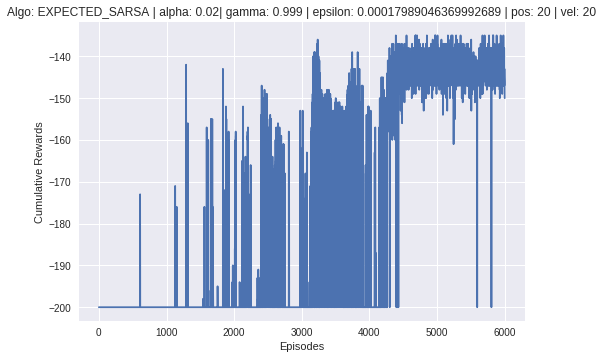

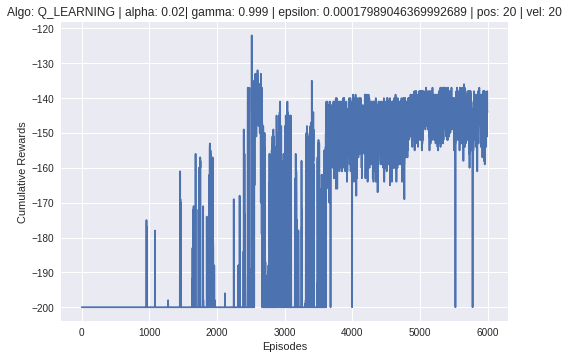

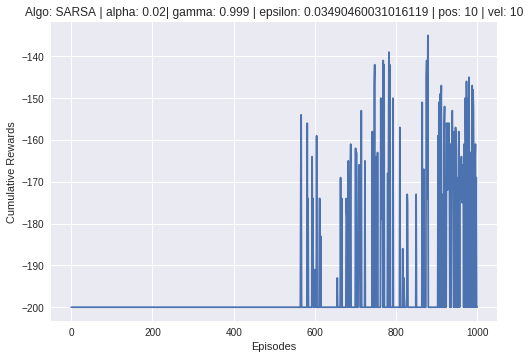

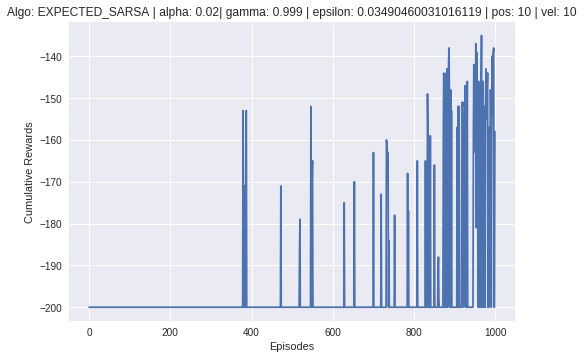

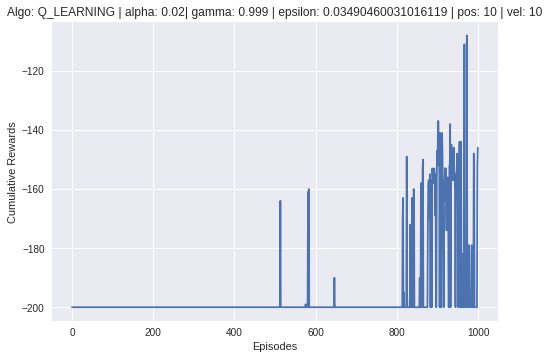

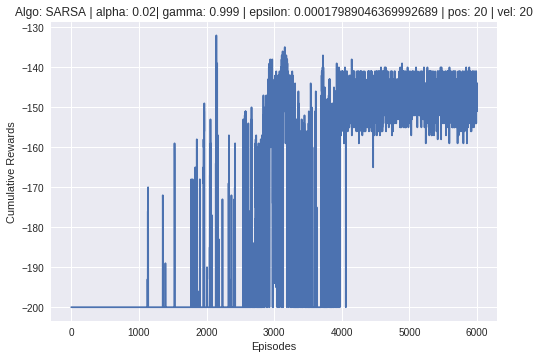

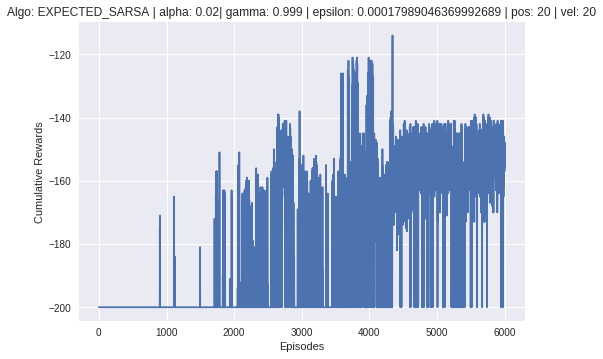

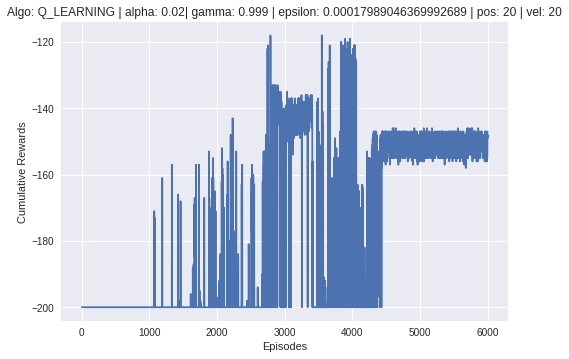

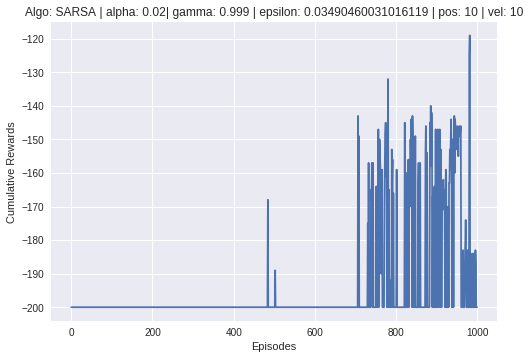

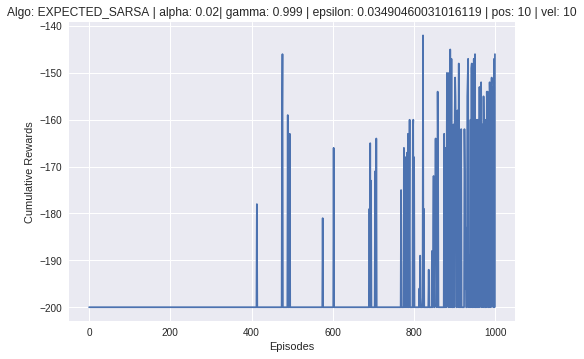

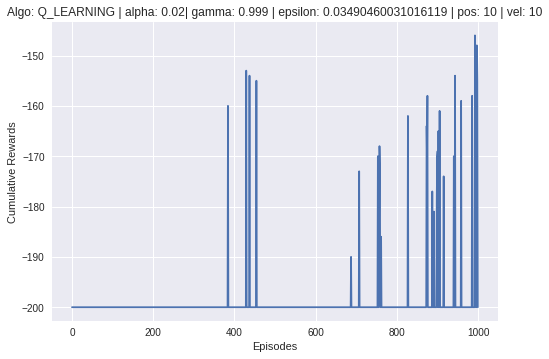

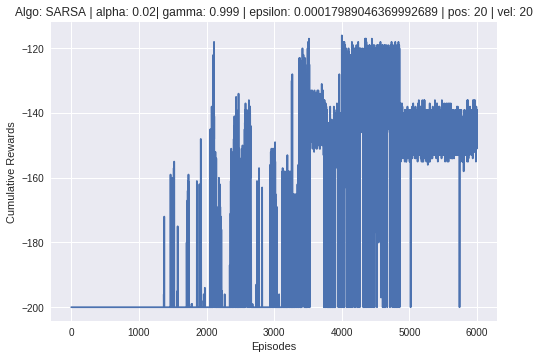

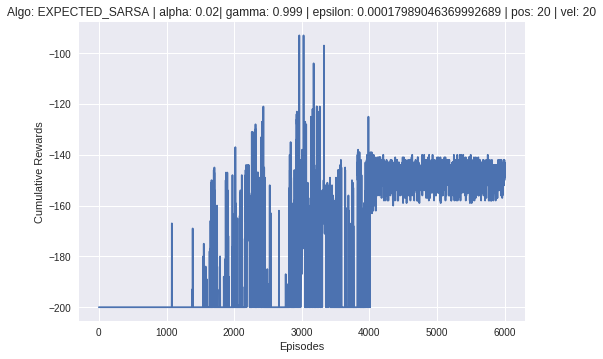

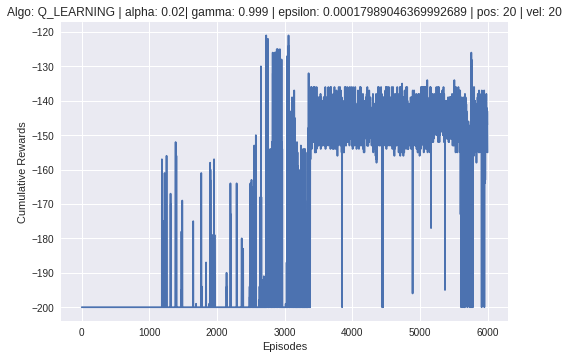

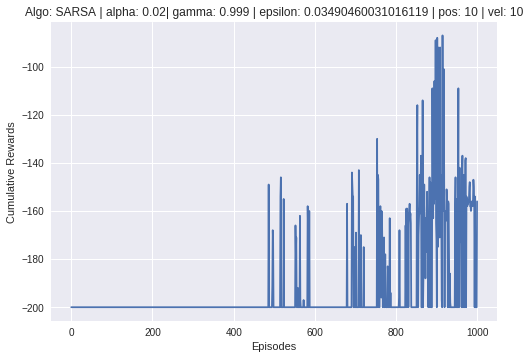

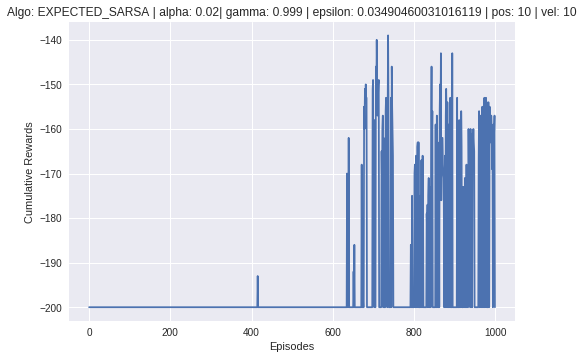

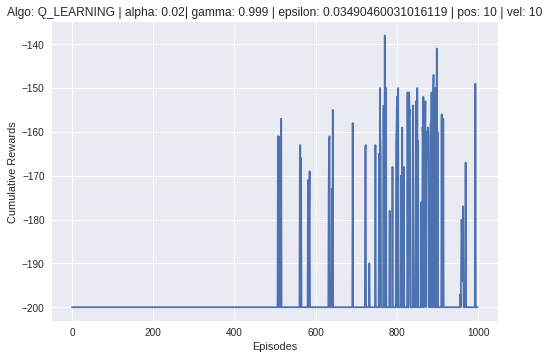

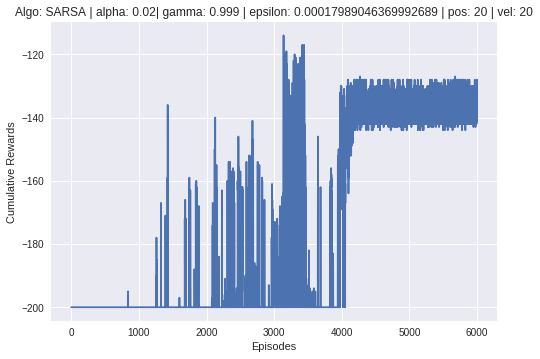

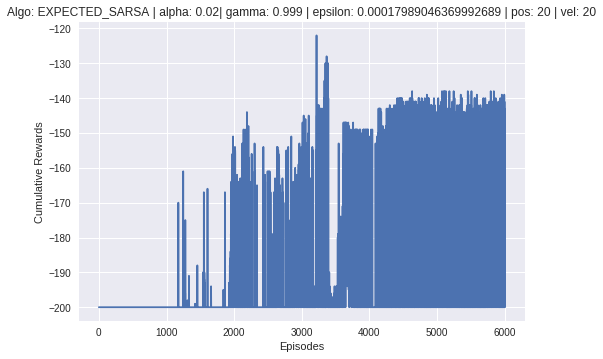

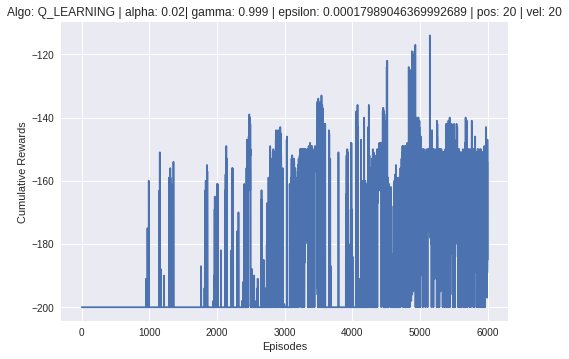

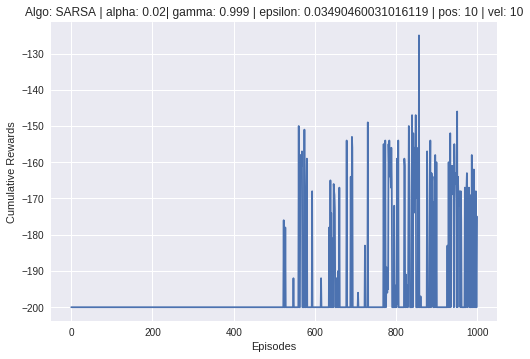

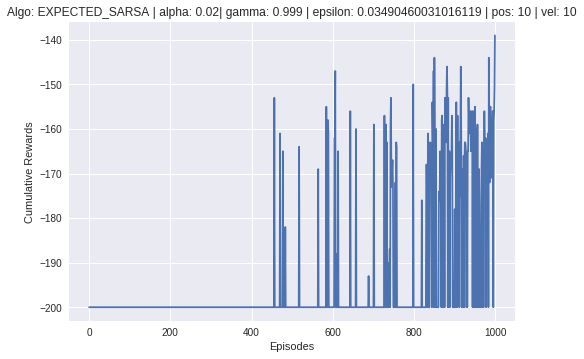

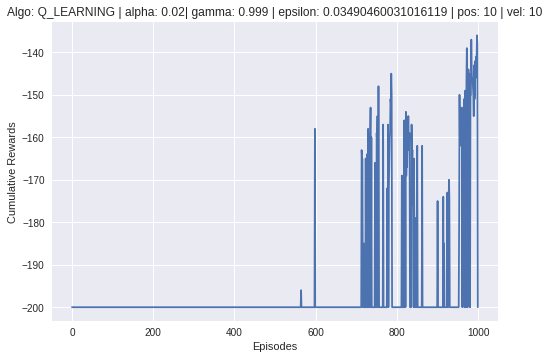

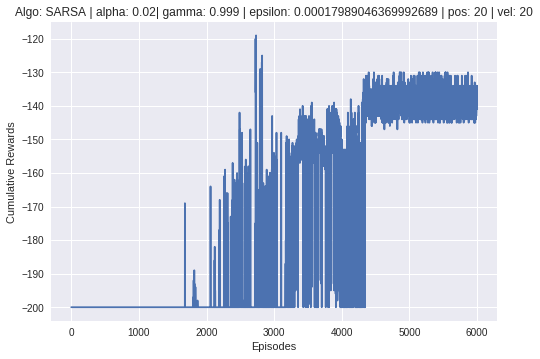

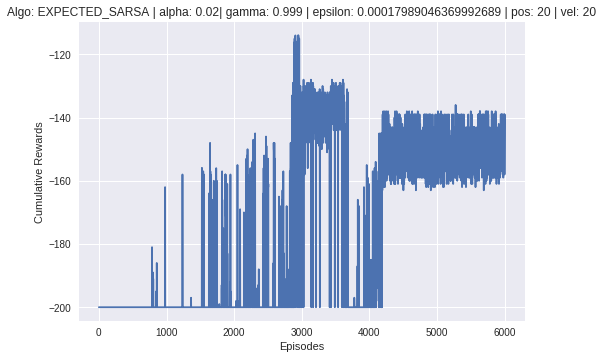

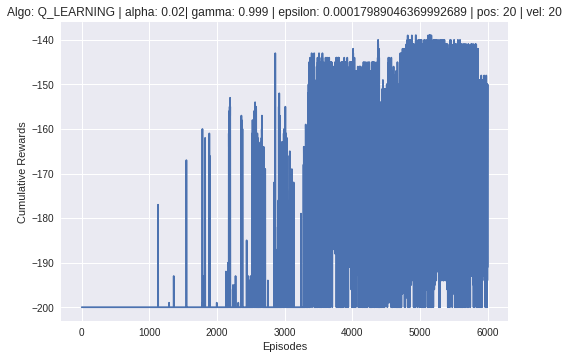

In [0]:
env = gym.make("MountainCar-v0")
a = Agent(env)

learning_rate = list()

sarsa_alpha_rewards_low = list()
exp_sarsa_alpha_rewards_low = list()
ql_report_alpha_low = list()

sarsa_alpha_rewards_high = list()
exp_sarsa_alpha_rewards_high = list()
ql_report_alpha_high = list()

position_bins_low = 10 #valori presi dal grafo precedente sulle dimensioni per 1000 iterazioni
velocity_bins_low = 10

position_bins_high = 20 #valori presi dal grafo precedente sulle dimensioni per 1000 iterazioni
velocity_bins_high = 20

epsilon = 0.1

dim1 = 1000
dim2 = 6000

for alpha in np.arange(0.1, 1.1, 0.1):
  benchmark(dim1, a, position_bins_low, velocity_bins_low, sarsa_alpha_rewards_low, SARSA, alpha, epsilon)
  benchmark(dim1, a, position_bins_low, velocity_bins_low, exp_sarsa_alpha_rewards_low, EXPECTED_SARSA, alpha, epsilon)
  benchmark(dim1, a, position_bins_low, velocity_bins_low, ql_report_alpha_low, QLEARNING, alpha, epsilon)
  
  benchmark(dim2, a, position_bins_high, velocity_bins_high, sarsa_alpha_rewards_high, SARSA, alpha, epsilon)
  benchmark(dim2, a, position_bins_high, velocity_bins_high, exp_sarsa_alpha_rewards_high, EXPECTED_SARSA, alpha, epsilon)
  benchmark(dim2, a, position_bins_high, velocity_bins_high, ql_report_alpha_high, QLEARNING, alpha, epsilon)
  
  learning_rate.append(alpha)



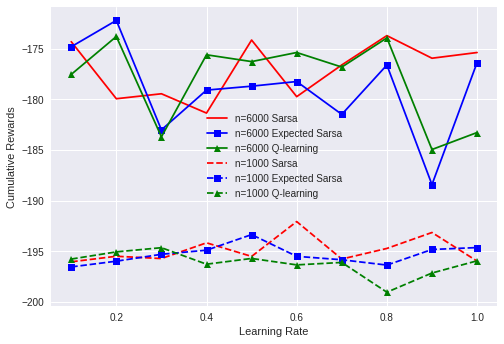

In [0]:
dump_plot('Learning Rate', learning_rate, sarsa_alpha_rewards_high, exp_sarsa_alpha_rewards_high, ql_report_alpha_high, sarsa_alpha_rewards_low, exp_sarsa_alpha_rewards_low, ql_report_alpha_low) 

# Raccolgo statistiche sulle prestazioni al variare di **epsilon**

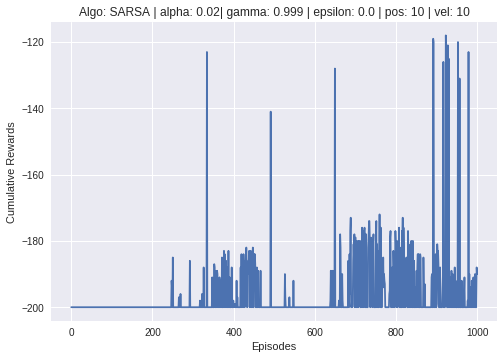

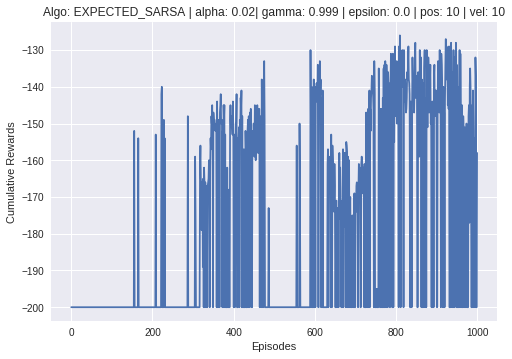

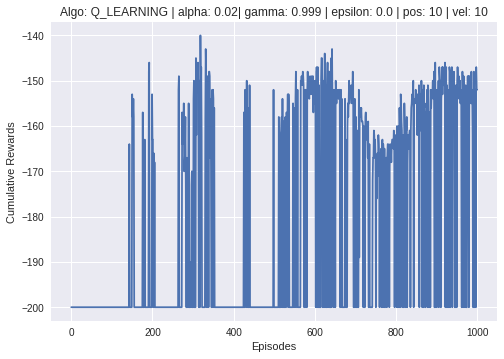

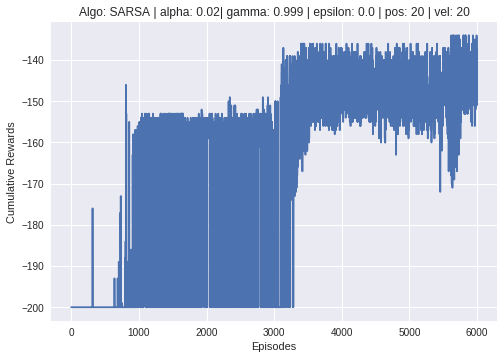

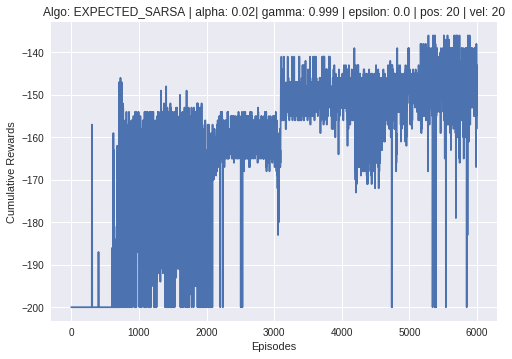

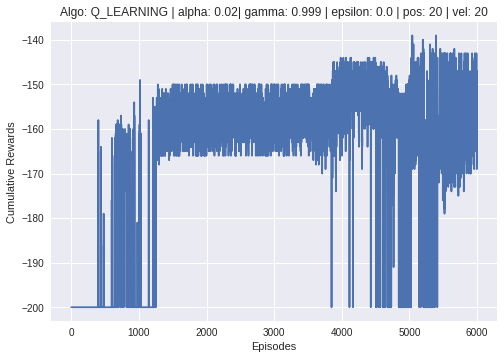

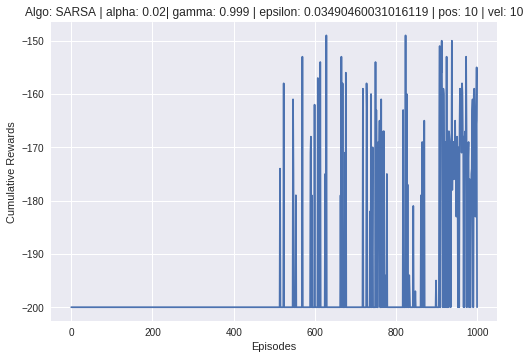

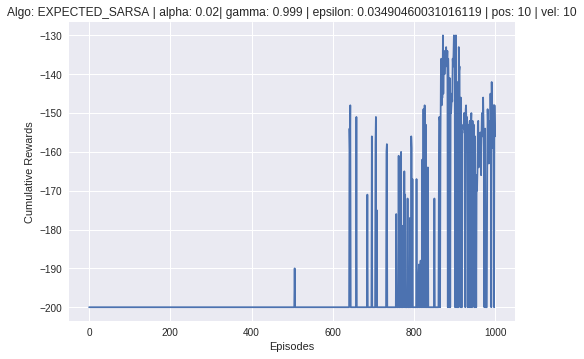

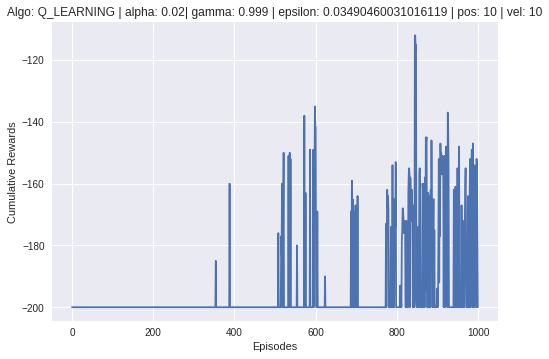

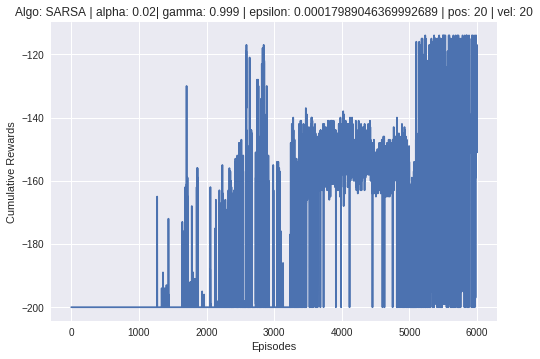

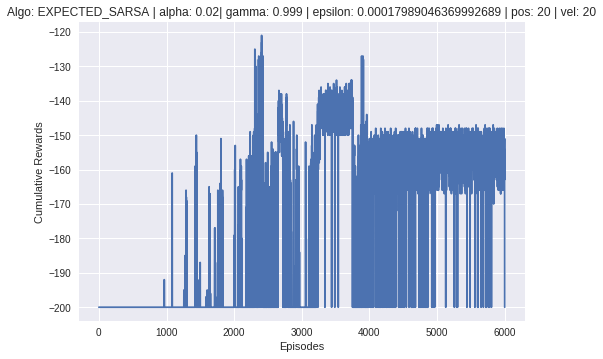

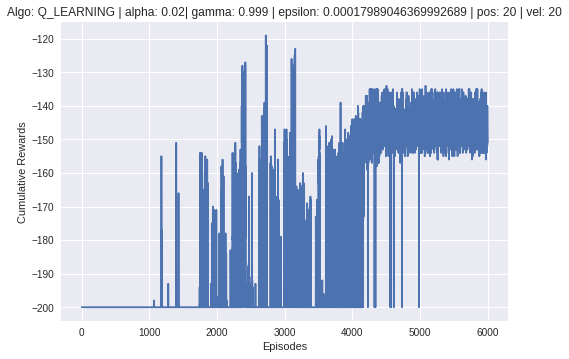

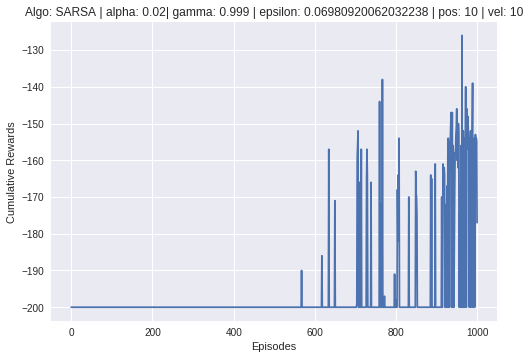

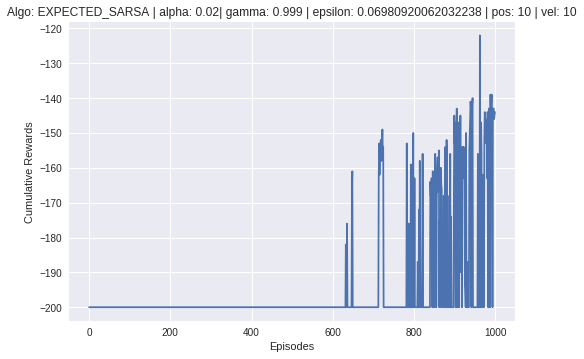

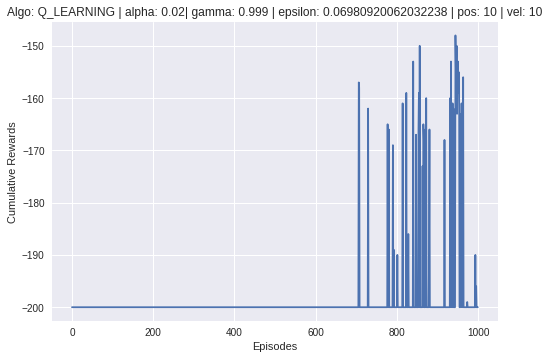

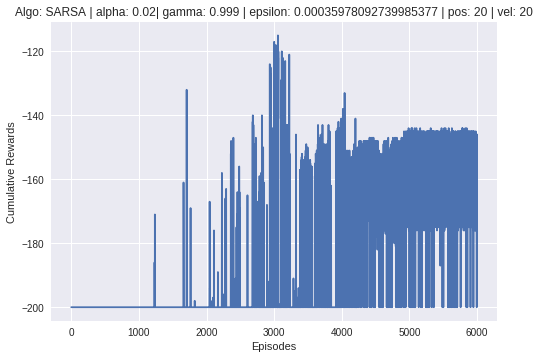

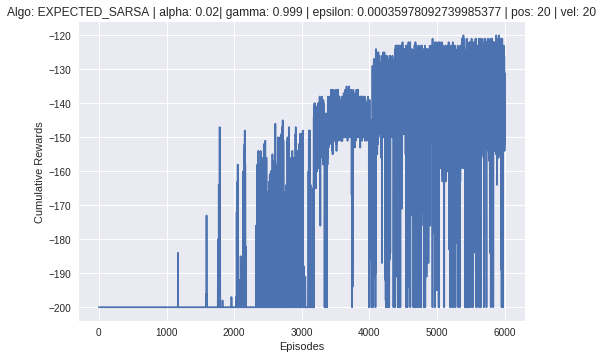

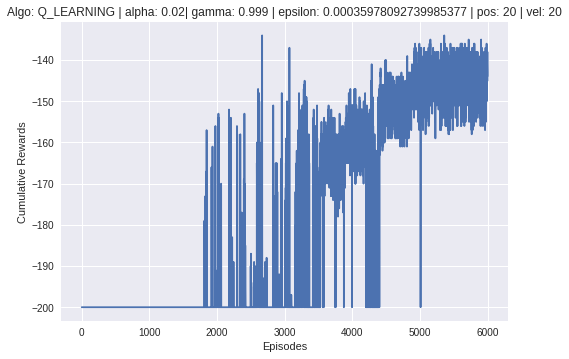

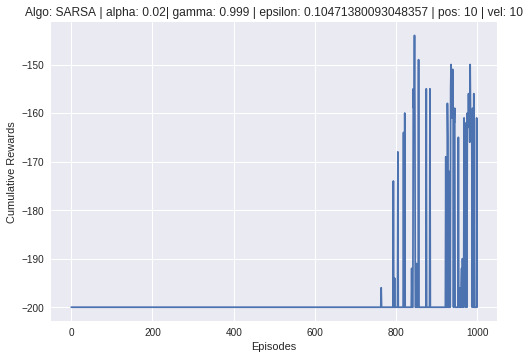

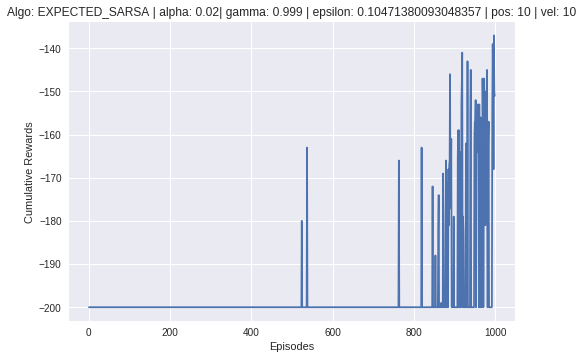

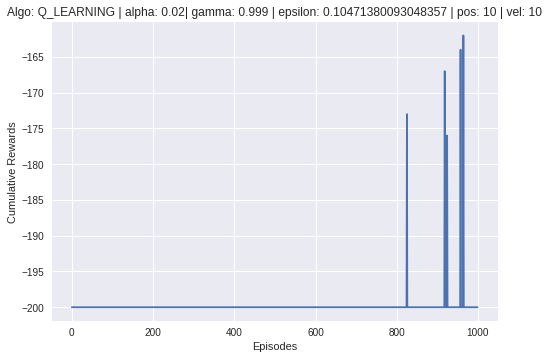

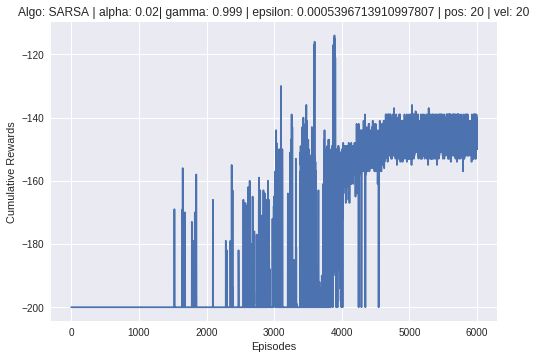

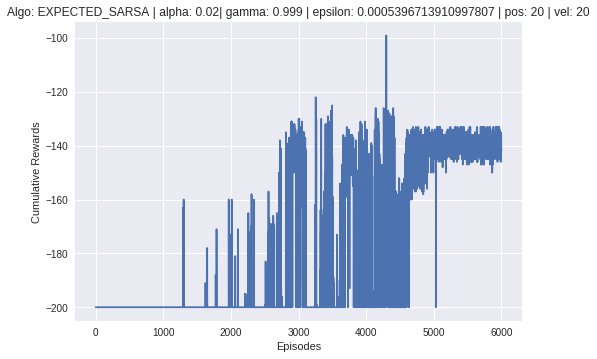

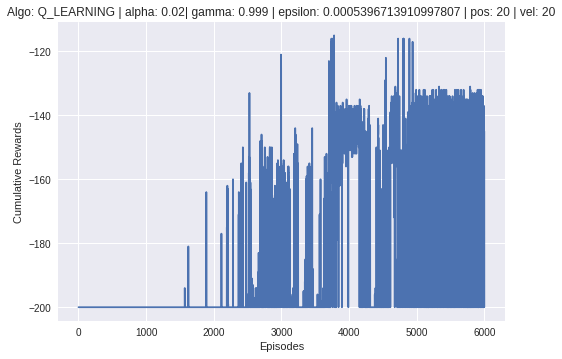

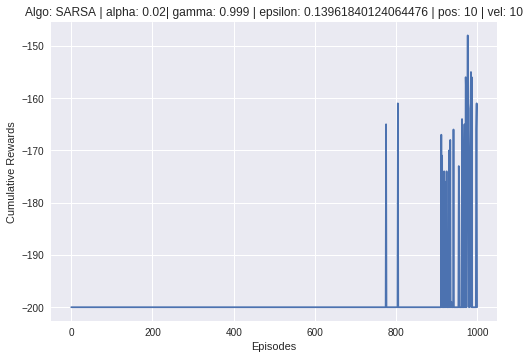

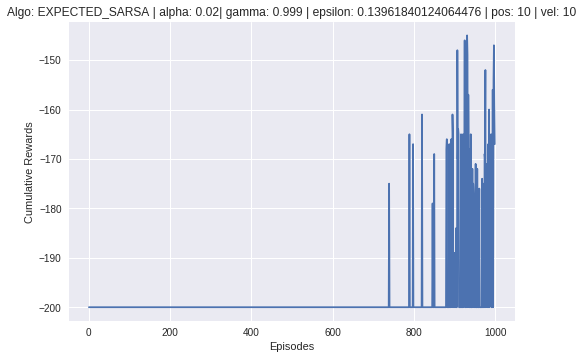

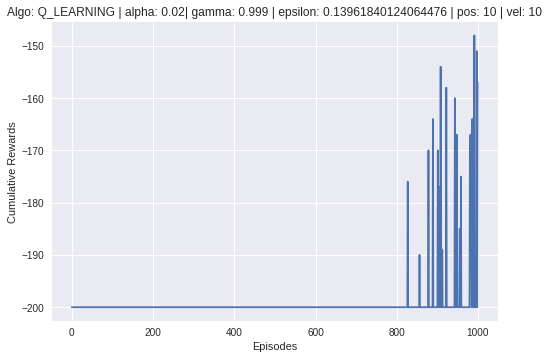

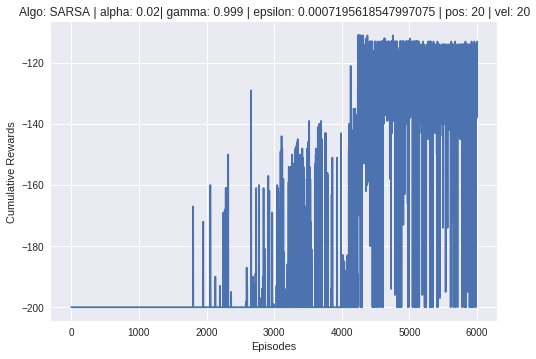

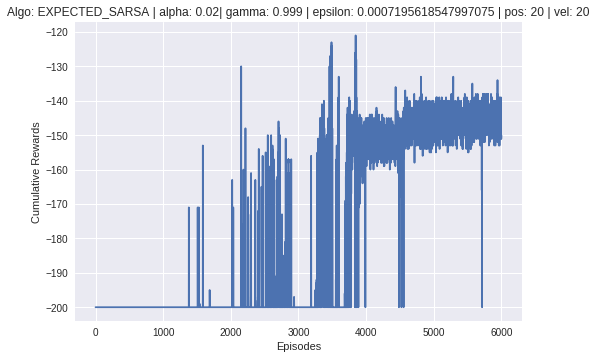

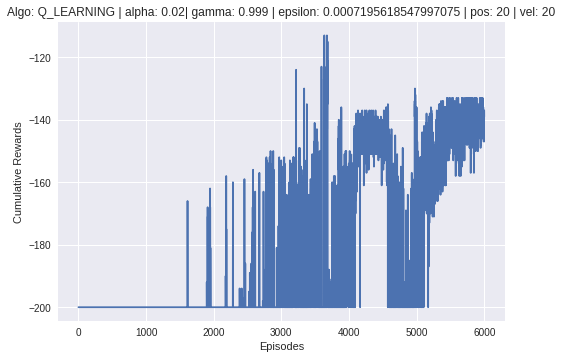

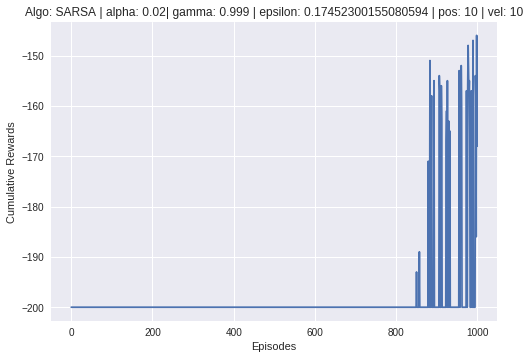

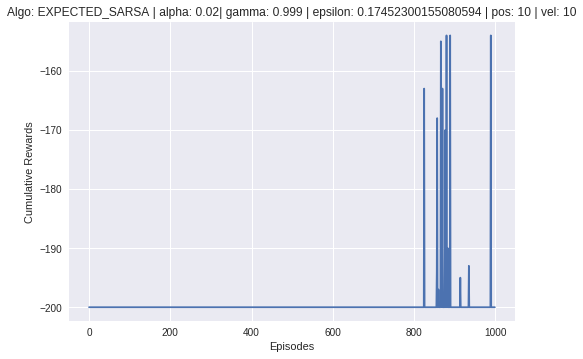

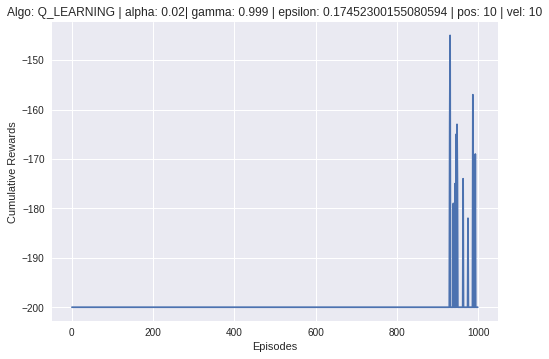

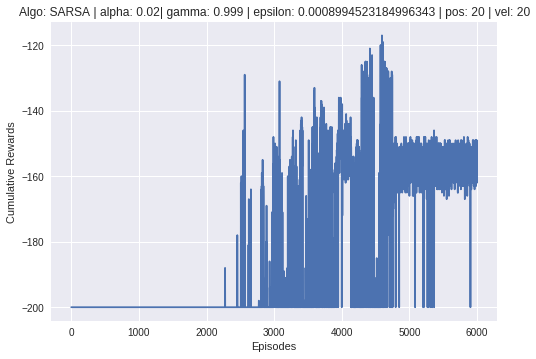

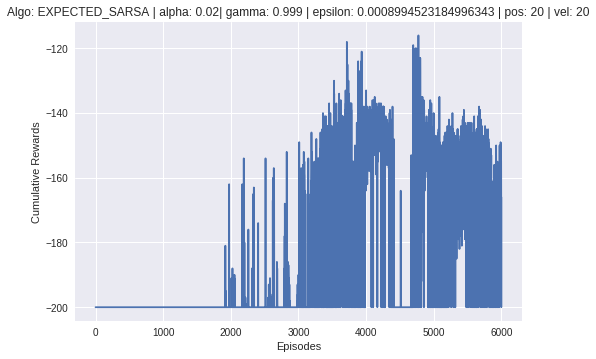

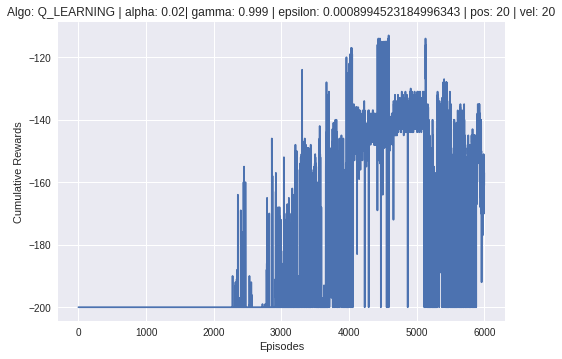

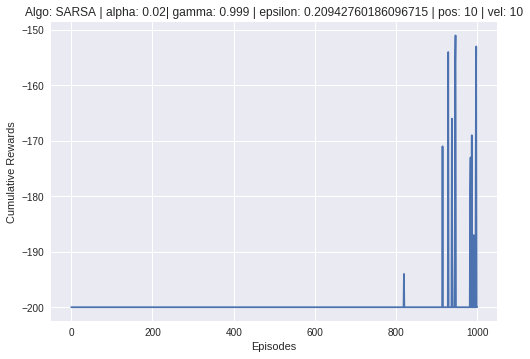

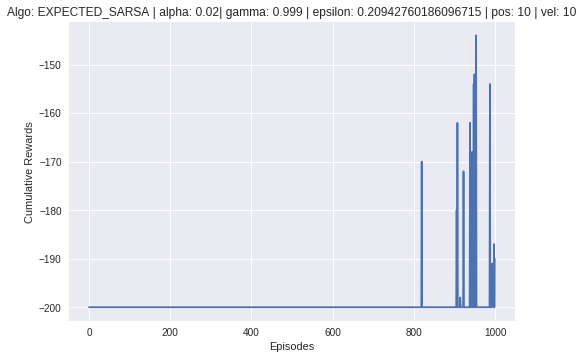

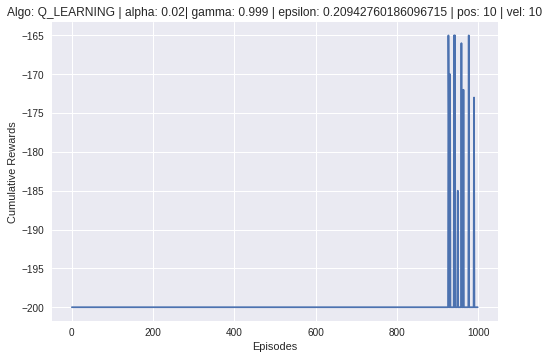

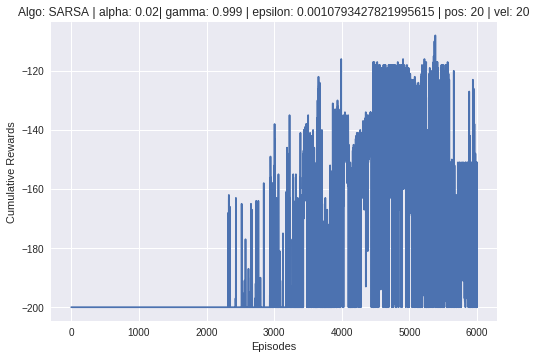

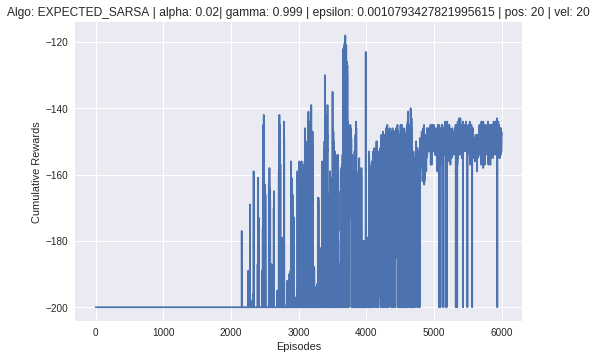

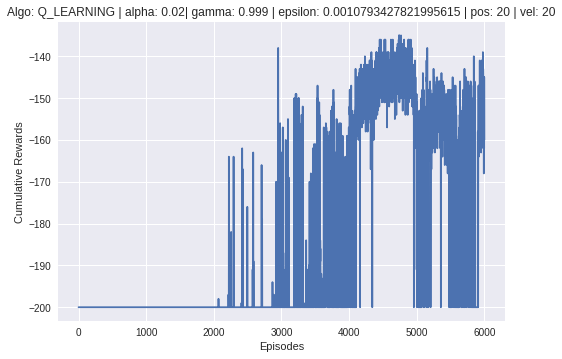

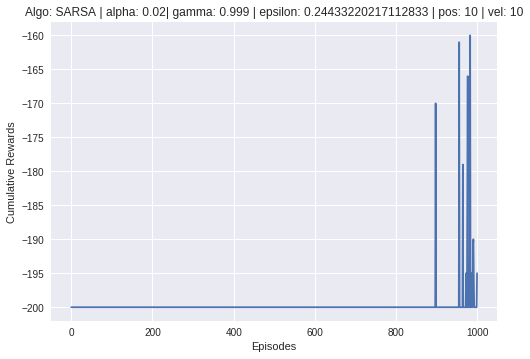

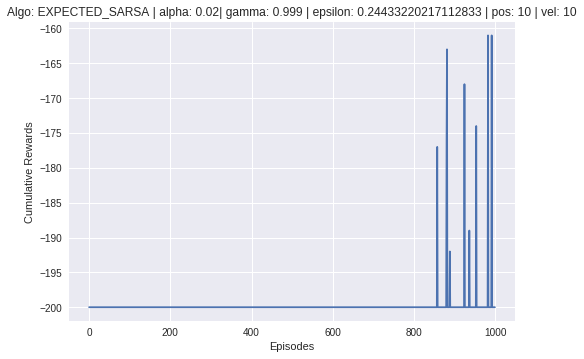

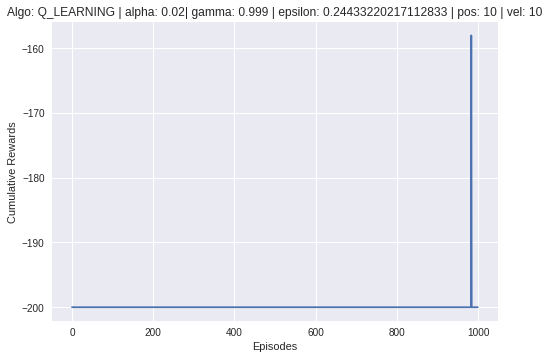

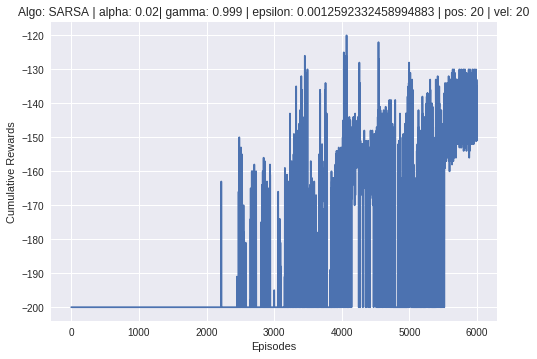

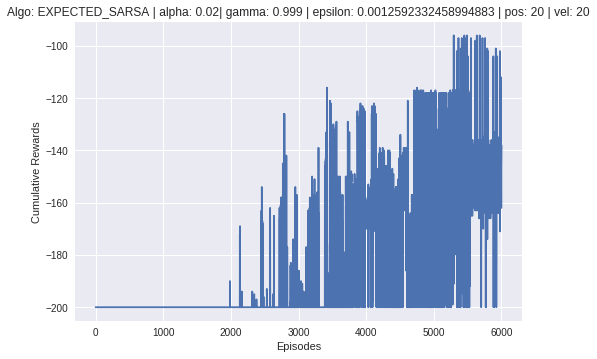

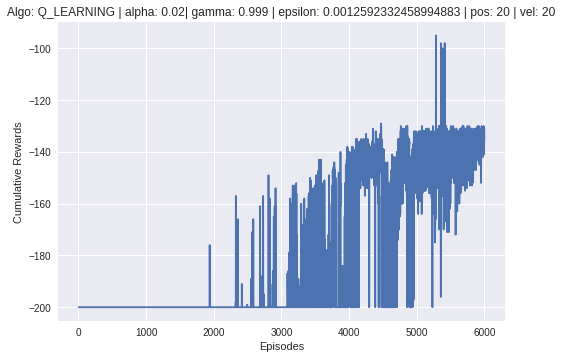

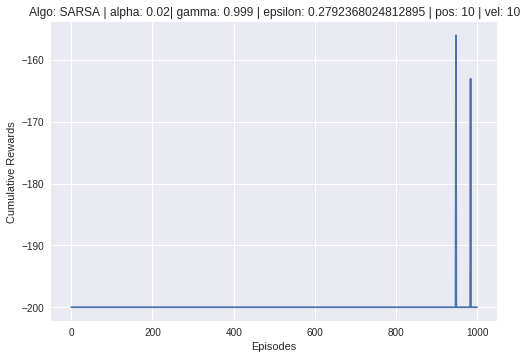

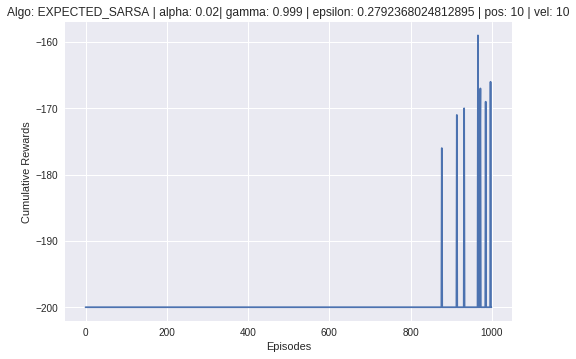

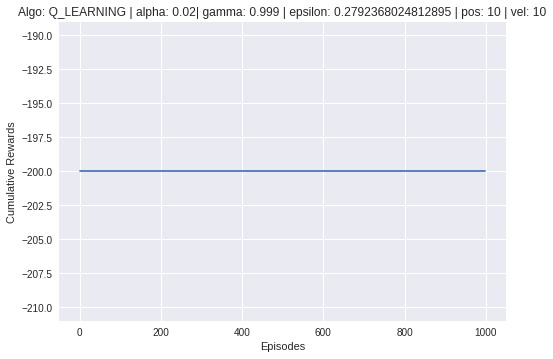

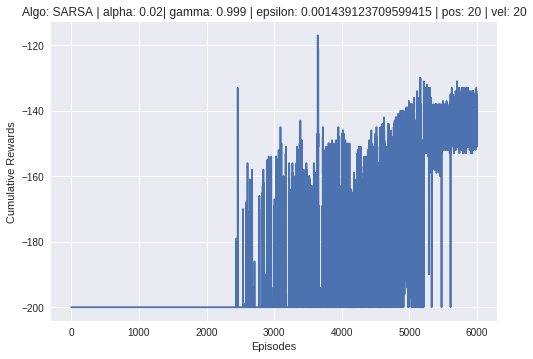

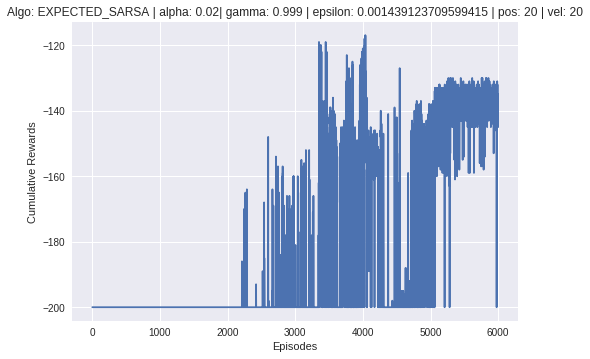

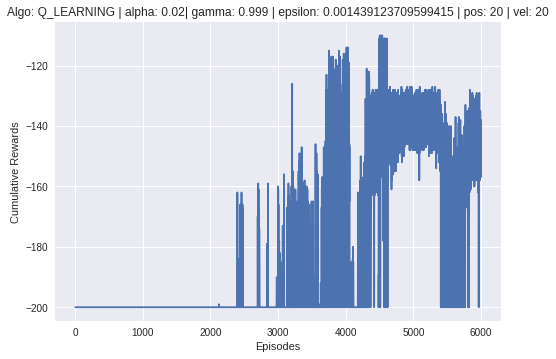

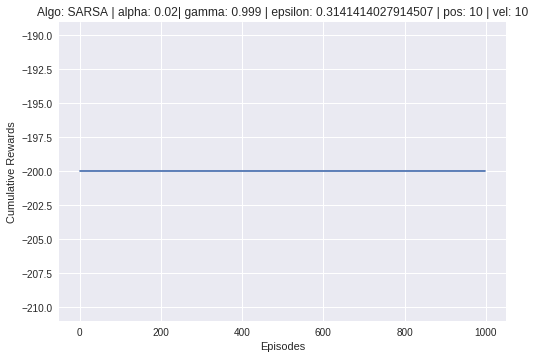

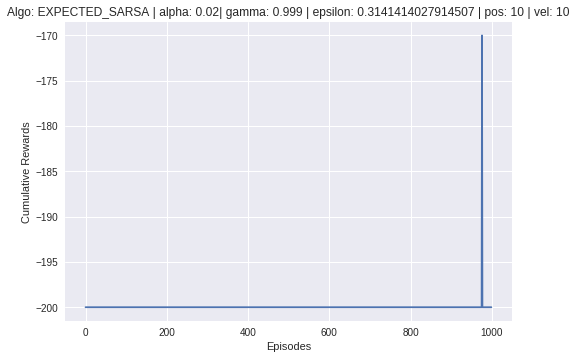

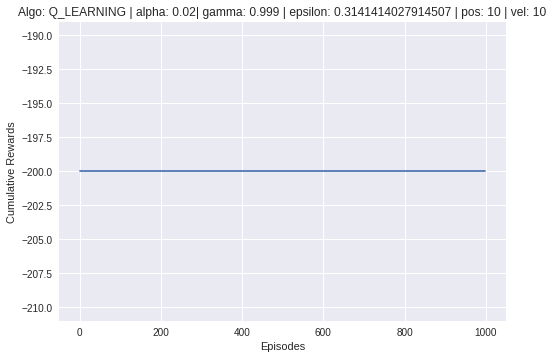

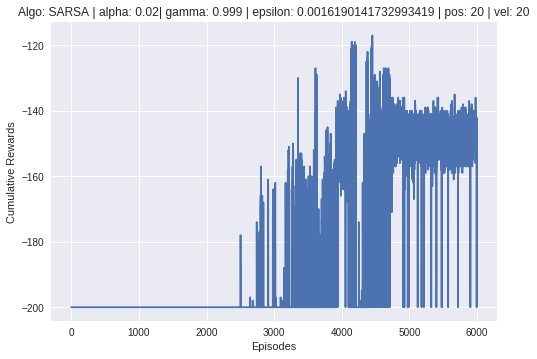

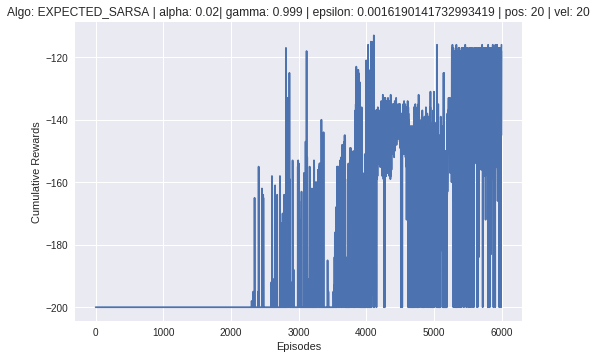

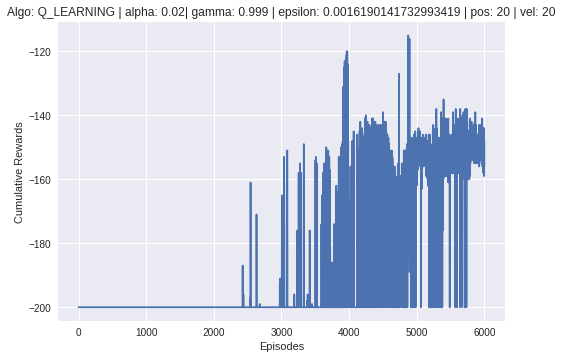

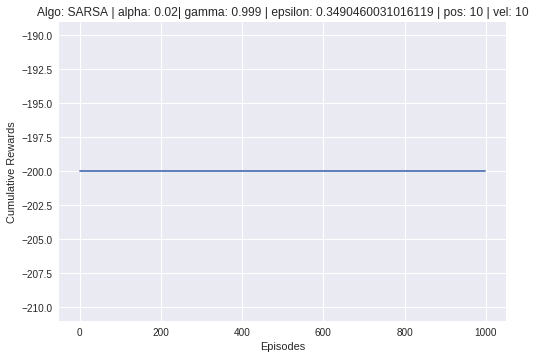

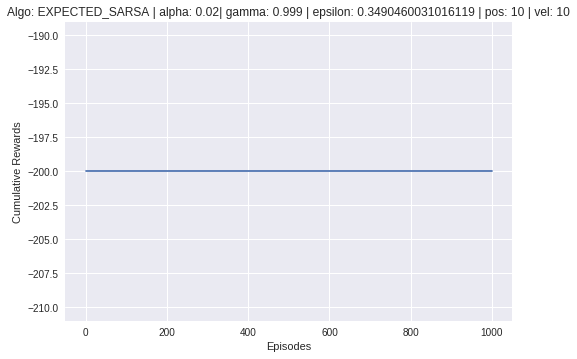

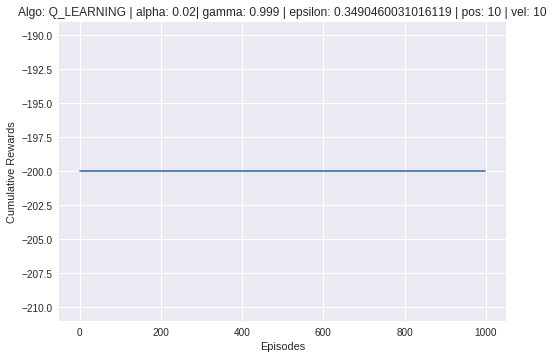

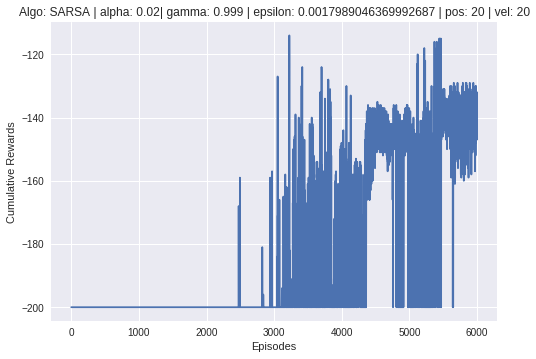

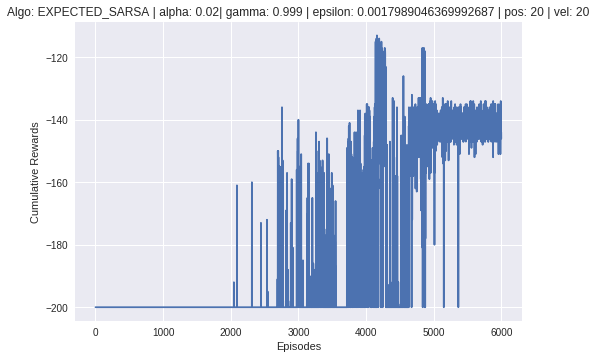

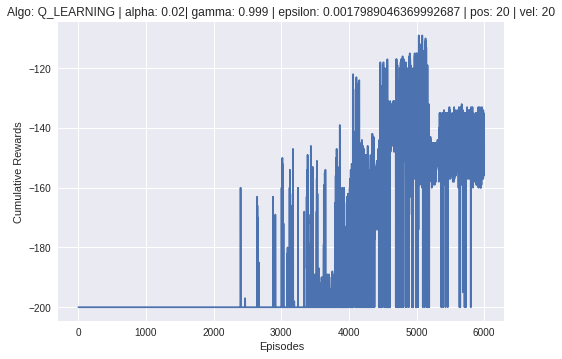

In [0]:
env = gym.make("MountainCar-v0")
a = Agent(env)

epsilon_list = list()

sarsa_epsilon_rewards_low = list()
exp_sarsa_epsilon_rewards_low = list()
ql_epsilon_low = list()

sarsa_epsilon_rewards_high = list()
exp_sarsa_epsilon_rewards_high = list()
ql_epsilon_high = list()

position_bins_low = 10 #valori presi dal grafo precedente sulle dimensioni per 1000 iterazioni
velocity_bins_low = 10

position_bins_high = 20 #valori presi dal grafo precedente sulle dimensioni per 1000 iterazioni
velocity_bins_high = 20
alpha = 0.2

dim1 = 1000
dim2 = 6000

for epsilon in np.arange(0.0, 1.1, 0.1):
  benchmark(dim1, a, position_bins_low, velocity_bins_low, sarsa_epsilon_rewards_low, SARSA, alpha, epsilon)
  benchmark(dim1, a, position_bins_low, velocity_bins_low, exp_sarsa_epsilon_rewards_low, EXPECTED_SARSA, alpha, epsilon)
  benchmark(dim1, a, position_bins_low, velocity_bins_low, ql_epsilon_low, QLEARNING, alpha, epsilon)
  
  benchmark(dim2, a, position_bins_high, velocity_bins_high, sarsa_epsilon_rewards_high, SARSA, alpha, epsilon)
  benchmark(dim2, a, position_bins_high, velocity_bins_high, exp_sarsa_epsilon_rewards_high, EXPECTED_SARSA, alpha, epsilon)
  benchmark(dim2, a, position_bins_high, velocity_bins_high, ql_epsilon_high, QLEARNING, alpha, epsilon)
  
  epsilon_list.append(epsilon)


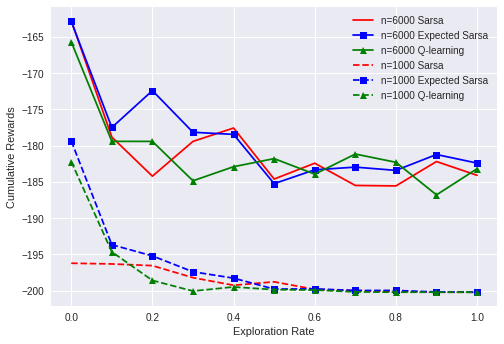

In [0]:
dump_plot('Exploration Rate', epsilon_list, sarsa_epsilon_rewards_high, exp_sarsa_epsilon_rewards_high, ql_epsilon_high, sarsa_epsilon_rewards_low, exp_sarsa_epsilon_rewards_low, ql_epsilon_low) 

# Testo i tre algoritmi con i loro parametri "migliori"


#################

Episode:  0
Reward:  -200.0
Total Rewards:  -200.0
Epsilon:  0.1

#################

Episode:  100
Reward:  -200.0
Total Rewards:  -20200.0
Epsilon:  0.09000000000000001

#################

Episode:  200
Reward:  -200.0
Total Rewards:  -40200.0
Epsilon:  0.08100000000000002

#################

Episode:  300
Reward:  -200.0
Total Rewards:  -60200.0
Epsilon:  0.0729

#################

Episode:  400
Reward:  -200.0
Total Rewards:  -80200.0
Epsilon:  0.06561

#################

Episode:  500
Reward:  -200.0
Total Rewards:  -100200.0
Epsilon:  0.05904900000000001

#################

Episode:  600
Reward:  -200.0
Total Rewards:  -120200.0
Epsilon:  0.05314410000000001

#################

Episode:  700
Reward:  -200.0
Total Rewards:  -140200.0
Epsilon:  0.04782969000000001

#################

Episode:  800
Reward:  -200.0
Total Rewards:  -160200.0
Epsilon:  0.04304672100000001

#################

Episode:  900
Reward:  -200.0
Total Rewards:  -180200.0
Epsilon:  0.03874204

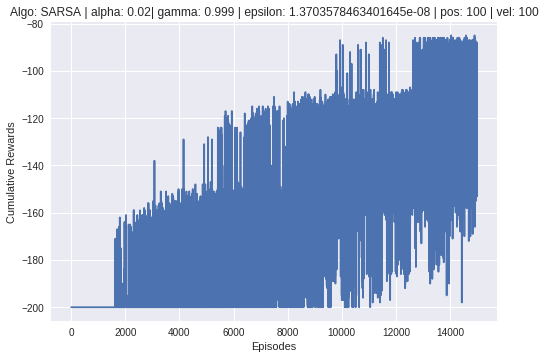


#################

Episode:  0
Reward:  -200.0
Total Rewards:  -200.0
Epsilon:  0.0

#################

Episode:  100
Reward:  -200.0
Total Rewards:  -20200.0
Epsilon:  0.0

#################

Episode:  200
Reward:  -200.0
Total Rewards:  -40200.0
Epsilon:  0.0

#################

Episode:  300
Reward:  -200.0
Total Rewards:  -60200.0
Epsilon:  0.0

#################

Episode:  400
Reward:  -200.0
Total Rewards:  -80200.0
Epsilon:  0.0

#################

Episode:  500
Reward:  -200.0
Total Rewards:  -100200.0
Epsilon:  0.0

#################

Episode:  600
Reward:  -200.0
Total Rewards:  -120200.0
Epsilon:  0.0

#################

Episode:  700
Reward:  -200.0
Total Rewards:  -140200.0
Epsilon:  0.0

#################

Episode:  800
Reward:  -200.0
Total Rewards:  -160200.0
Epsilon:  0.0

#################

Episode:  900
Reward:  -200.0
Total Rewards:  -180200.0
Epsilon:  0.0

#################

Episode:  1000
Reward:  -200.0
Total Rewards:  -200200.0
Epsilon:  0.0

#################

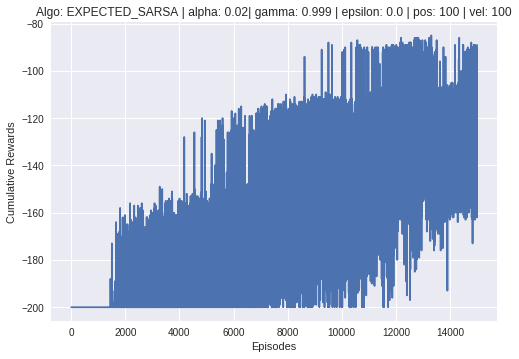


#################

Episode:  0
Reward:  -200.0
Total Rewards:  -200.0
Epsilon:  0.0

#################

Episode:  100
Reward:  -200.0
Total Rewards:  -20200.0
Epsilon:  0.0

#################

Episode:  200
Reward:  -200.0
Total Rewards:  -40200.0
Epsilon:  0.0

#################

Episode:  300
Reward:  -200.0
Total Rewards:  -60200.0
Epsilon:  0.0

#################

Episode:  400
Reward:  -200.0
Total Rewards:  -80200.0
Epsilon:  0.0

#################

Episode:  500
Reward:  -200.0
Total Rewards:  -100200.0
Epsilon:  0.0

#################

Episode:  600
Reward:  -200.0
Total Rewards:  -120200.0
Epsilon:  0.0

#################

Episode:  700
Reward:  -200.0
Total Rewards:  -140200.0
Epsilon:  0.0

#################

Episode:  800
Reward:  -200.0
Total Rewards:  -160200.0
Epsilon:  0.0

#################

Episode:  900
Reward:  -200.0
Total Rewards:  -180200.0
Epsilon:  0.0

#################

Episode:  1000
Reward:  -200.0
Total Rewards:  -200200.0
Epsilon:  0.0

#################

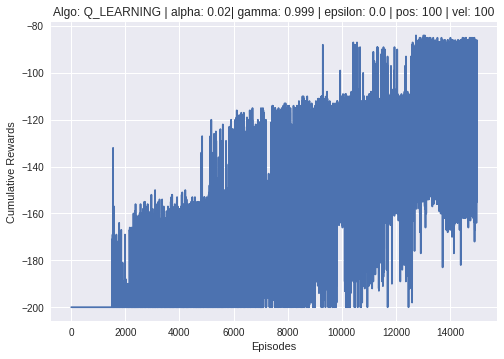

In [0]:
env = gym.make("MountainCar-v0")
a = Agent(env)


sarsa_final_rewards = list()
exp_sarsa_final_rewards = list()
ql_final_rewards = list()

dim = 15000
position_bins = 100 
velocity_bins = 100

a.training(dim, position_bins, velocity_bins, 0.8, 0.999, 0.1, SARSA, debug = True)
a.statistics()
a.training(dim, position_bins, velocity_bins, 0.8, 0.999, 0, EXPECTED_SARSA, debug = True)
a.statistics()
a.training(dim, position_bins, velocity_bins, 0.8, 0.999, 0, QLEARNING, debug = True)  
a.statistics()

# Colleziono video delle varie fasi di training dell' ultimo agente

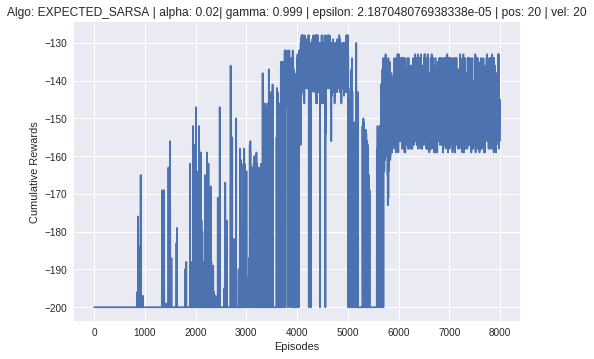

['video/openaigym.video.0.526.video003000.mp4', 'video/openaigym.video.0.526.video007000.mp4', 'video/openaigym.video.0.526.video004000.mp4', 'video/openaigym.video.0.526.video000216.mp4', 'video/openaigym.video.0.526.video001000.mp4', 'video/openaigym.video.0.526.video000000.mp4', 'video/openaigym.video.0.526.video000512.mp4', 'video/openaigym.video.0.526.video000343.mp4', 'video/openaigym.video.0.526.video000027.mp4', 'video/openaigym.video.0.526.video000125.mp4', 'video/openaigym.video.0.526.video005000.mp4', 'video/openaigym.video.0.526.video000064.mp4', 'video/openaigym.video.0.526.video002000.mp4', 'video/openaigym.video.0.526.video000001.mp4', 'video/openaigym.video.0.526.video000729.mp4', 'video/openaigym.video.0.526.video000008.mp4', 'video/openaigym.video.0.526.video006000.mp4']
video/openaigym.video.0.526.video007000.mp4


In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!rm -rf video

display = Display(visible=0, size=(400, 300))
display.start()
env = wrap_env(gym.make("MountainCar-v0"))
a = Agent(env)
a.training(8000, 20, 20, 0.8, 0.999, 0.1, EXPECTED_SARSA)
a.statistics()
display.stop()
env.close()
show_video()